# Tải dữ liệu

In [1]:
!gdown 1rIkQWBMmaW-kqH9xM7ZciTUSG6P28wTY
!unzip /content/signals.zip

Downloading...
From: https://drive.google.com/uc?id=1rIkQWBMmaW-kqH9xM7ZciTUSG6P28wTY
To: /content/signals.zip
100% 6.74M/6.74M [00:00<00:00, 99.2MB/s]
Archive:  /content/signals.zip
replace signals/NguyenAmHuanLuyen-16k/23MTL/a.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: signals/NguyenAmHuanLuyen-16k/23MTL/a.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/23MTL/e.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/23MTL/i.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/23MTL/o.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/23MTL/u.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/24FTL/a.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/24FTL/e.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/24FTL/i.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/24FTL/o.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/24FTL/u.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/25MLM/a.wav  
  inflating: signals/NguyenAmHuanLuyen-16k/25MLM/e.wav  
  inflating: signals/NguyenAmHuanLuyen-16k

# Bài 1 - Vẽ ảnh phổ

In [2]:
config = {
  "train_path":"signals/NguyenAmHuanLuyen-16k",
  "valid_path":"signals/NguyenAmKiemThu-16k",
}


In [3]:
import os
import glob
import scipy
import numpy as np

def getWavFileContents(pathFile):
    sample_rate, data = scipy.io.wavfile.read(pathFile)
    data = np.array(data, dtype=float)
    length = data.shape[0] / sample_rate
    return sample_rate, data, length

class SignalDataset():
  def __init__(self, data_directory):
    self.audio_paths = self.load(data_directory)

  def __getitem__(self, idx):
    audio_path = self.audio_paths[idx]

    # ==== get label =====================
    filename = os.path.basename(audio_path)
    label = filename.split(".")[0]
    # ====================================

    # ==== read data =====================
    sample_rate, data, length = getWavFileContents(audio_path)
    # ====================================

    # === get human say ==================
    human = self.audio_paths[idx].split("/")[-2]
    # ====================================

    return (sample_rate, data, length), human , label

  def __len__(self):
    return len(self.audio_paths)

  def load(self, data_directory):
    audio_paths = []
    for audio_path in glob.glob(data_directory+"/**/*.wav"):
        audio_paths.append(audio_path)
    return audio_paths

In [4]:
import os
print(os.listdir(config["train_path"]))

['38MDS', '29MHN', '23MTL', '43MNT', '28MVN', '37MDS', '44MTT', '33MHP', '40MHS', '34MQP', '42FQT', '41MVS', '30FTN', '39MTS', '24FTL', '27MCM', '35MMQ', '25MLM', '36MAQ', '45MDV', '32MTP']


In [5]:
train_data = SignalDataset(config["train_path"])
valid_data = SignalDataset(config["valid_path"])

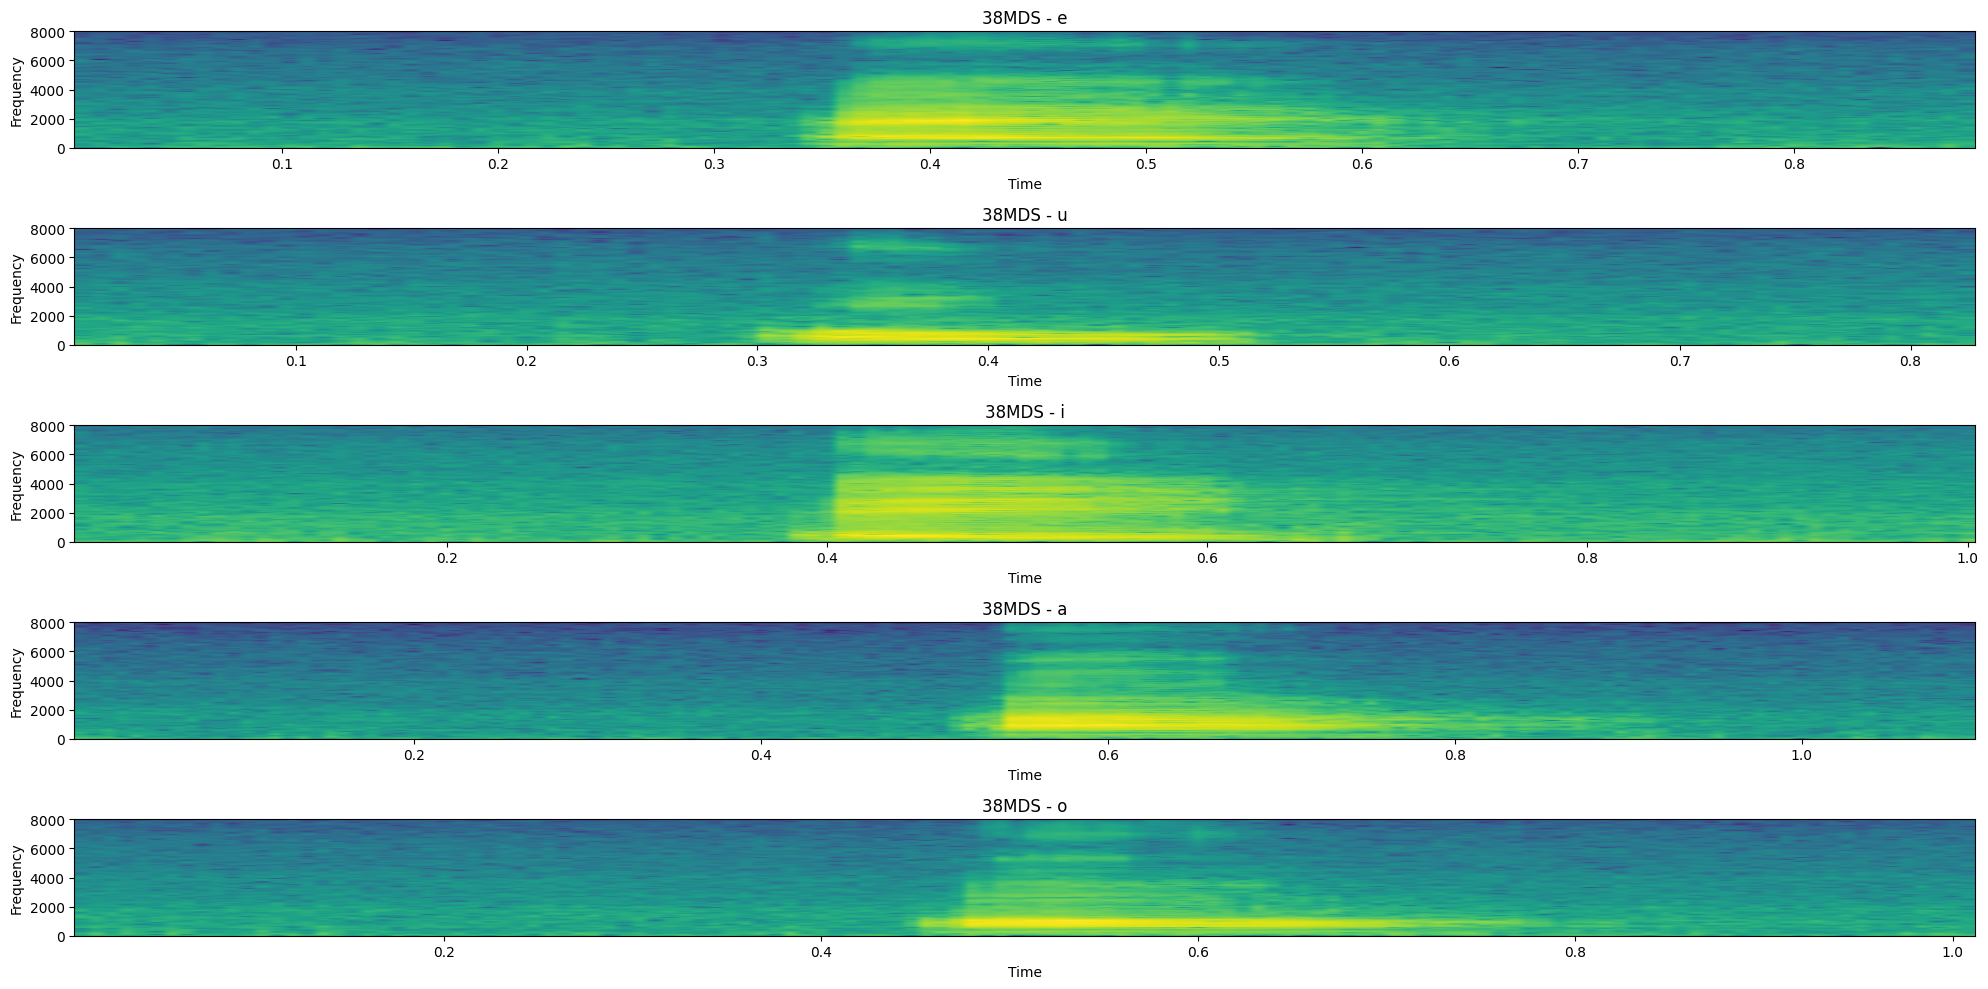

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(5)
fig.figsize = (20,30)
for (i) in range(5):
  (sample_rate, data, length), human,label = train_data[i]
  time = np.linspace(0., length, data.shape[0])
  axs[i].set_title("{} - {}".format(human, label))
  axs[i].specgram(data, Fs = sample_rate)
  axs[i].set(xlabel='Time', ylabel='Frequency')

fig.tight_layout()
fig.show()

# Bài 1 - Ước tính Formant tự động

In [7]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import lfilter
import glob

In [8]:
config = {
  "train_path":"signals/NguyenAmHuanLuyen-16k",
  "valid_path":"signals/NguyenAmKiemThu-16k",
}

In [9]:
def getSilenceAndSound(file_path):

  # ==== get label =====================
  filename = os.path.basename(file_path)
  # ====================================

  # === get human say ==================
  human = file_path.split("/")[-2]
  # ====================================

  # Load audio file
  y, fs = librosa.load(file_path, sr=None)

  # Calculate Short-Time Energy (STE)
  window_size = 0.03  # Size of the window (30 ms)
  overlap = 0.0  # Overlap between windows (50%)
  ste_threshold = 0.01  # STE threshold for classifying sound and silence

  # Calculate window parameters
  window_length = int(window_size * fs)
  overlap_length = int(overlap * window_length)

  # Calculate STE for each window
  ste = np.zeros_like(y)
  for i in range(0, len(y) - window_length, window_length - overlap_length):
      window = y[i:i + window_length]
      ste[i:i + window_length] = np.sum(window ** 2)

  # Classify sound and silence
  sound_segments = y[ste > ste_threshold]
  silence_segments = y[ste <= ste_threshold]

  # Create time vectors
  time_sound = np.arange(len(sound_segments)) / fs
  time_silence = np.arange(len(silence_segments)) / fs

  return fs, sound_segments, time_sound, silence_segments, time_silence

In [10]:
# This function is copied directly from https://github.com/cournape/talkbox/blob/master/scikits/talkbox/linpred/py_lpc.py
# Copyright (c) 2008 Cournapeau David
# (MIT licensed)
def levinson_1d(r, order):
    """Levinson-Durbin recursion, to efficiently solve symmetric linear systems
    with toeplitz structure.

    Parameters
    ---------
    r : array-like
        input array to invert (since the matrix is symmetric Toeplitz, the
        corresponding pxp matrix is defined by p items only). Generally the
        autocorrelation of the signal for linear prediction coefficients
        estimation. The first item must be a non zero real.

    Notes
    ----
    This implementation is in python, hence unsuitable for any serious
    computation. Use it as educational and reference purpose only.

    Levinson is a well-known algorithm to solve the Hermitian toeplitz
    equation:

                       _          _
        -R[1] = R[0]   R[1]   ... R[p-1]    a[1]
         :      :      :          :      *  :
         :      :      :          _      *  :
        -R[p] = R[p-1] R[p-2] ... R[0]      a[p]
                       _
    with respect to a (  is the complex conjugate). Using the special symmetry
    in the matrix, the inversion can be done in O(p^2) instead of O(p^3).
    """
    r = np.atleast_1d(r)
    if r.ndim > 1:
        raise ValueError("Only rank 1 are supported for now.")

    n = r.size
    if n < 1:
        raise ValueError("Cannot operate on empty array !")
    elif order > n - 1:
        raise ValueError("Order should be <= size-1")

    if not np.isreal(r[0]):
        raise ValueError("First item of input must be real.")
    elif not np.isfinite(1/r[0]):
        raise ValueError("First item should be != 0")

    # Estimated coefficients
    a = np.empty(order+1, r.dtype)
    # temporary array
    t = np.empty(order+1, r.dtype)
    # Reflection coefficients
    k = np.empty(order, r.dtype)

    a[0] = 1.
    e = r[0]

    for i in range(1, order+1):
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k[i-1] = -acc / e
        a[i] = k[i-1]

        for j in range(order):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])

    return a, e, k

In [11]:
def lpc(wave, order):
    """Compute LPC of the waveform.
    a: the LPC coefficients
    e: the total error
    k: the reflection coefficients

    Typically only a is required.
    """
    # only use right half of autocorrelation, normalised by total length
    autocorr = scipy.signal.correlate(wave, wave)[len(wave)-1:]/len(wave)
    a, e, k  = levinson_1d(autocorr, order)
    return a,e,k

In [12]:
def formant_estimation(audio_path):
  fs, y, _, _, _ = getSilenceAndSound(audio_path)
  dt = 1/fs;
  I0 = round(0.0/dt);
  Iend = round(0.75/dt);
  x = y[I0:Iend];
  x1 = x * np.hamming(x.shape[0]);

  preemph = [1, 0.63];
  x1 = lfilter(preemph, 1, x1);

  A = lpc(x1, order=12)[0]
  rts = np.roots(A)
  rts = rts[np.imag(rts) >= 0]
  angz = np.arctan2(np.imag(rts), np.real(rts))
  frqs = angz * fs / (2 *  np.pi)

  bw = -1/2*(fs/(2*np.pi))*np.log(abs(rts))
  formants = []
  for i in range(len(bw)):
    if (frqs[i] > 90) and (bw[i] < 400):
      formants.append(frqs[i])

  formants.sort()

  return formants

In [13]:
datalist = {
    "a":{"f1": [], "f2": [], "f3": []},
    "e":{"f1": [], "f2": [], "f3": []},
    "i":{"f1": [], "f2": [], "f3": []},
    "o":{"f1": [], "f2": [], "f3": []},
    "u":{"f1": [], "f2": [], "f3": []},
}
f1_list = []
f2_list = []
f3_list = []

from scipy.signal import lfilter

# humans = ["24FTL", "25MLM", "27MCM", "28MVN"]
humans = os.listdir(config["train_path"])

for h in humans:
  fnames = glob.glob(config["train_path"] + "/" +h+"/*.wav")
  fnames.sort()
  for audio_path in fnames:
      label = os.path.basename(audio_path).split(".")[0]
      human = audio_path.split("/")[-2]
      formants = formant_estimation(audio_path)

      print(h, "/" + label + "/", np.int32(formants)[:3])

      f1= formants[0]
      f2= formants[1]
      f3= formants[2]
      datalist[label]["f1"].append(f1)
      datalist[label]["f2"].append(f2)
      datalist[label]["f3"].append(f3)

38MDS /a/ [ 898 1420 2541]
38MDS /e/ [ 688 1799 2241]
38MDS /i/ [ 374 2155 2839]
38MDS /o/ [ 711  994 2335]
38MDS /u/ [ 415  786 2924]
29MHN /a/ [ 834 1464 2366]
29MHN /e/ [ 663 1828 2548]
29MHN /i/ [ 408 2047 2799]
29MHN /o/ [ 728  960 2745]
29MHN /u/ [ 481  633 2840]
23MTL /a/ [ 682 1471 1882]
23MTL /e/ [ 628 1844 2322]
23MTL /i/ [ 373 1845 2590]
23MTL /o/ [ 684 1009 1965]
23MTL /u/ [ 441  784 3340]
43MNT /a/ [ 738 1650 2684]
43MNT /e/ [ 703 2052 2810]
43MNT /i/ [ 315 2111 3160]
43MNT /o/ [ 725 1070 2633]
43MNT /u/ [ 342  744 1731]
28MVN /a/ [1108 1441 2084]
28MVN /e/ [ 669 1926 2811]
28MVN /i/ [ 411 2257 3043]
28MVN /o/ [ 857 1055 2049]
28MVN /u/ [ 446  718 3114]
37MDS /a/ [ 759 1327 1636]
37MDS /e/ [ 681 1178 2113]
37MDS /i/ [ 366 2709 4000]
37MDS /o/ [ 688 1069 2759]
37MDS /u/ [ 376  730 3639]
44MTT /a/ [ 713 1395 2288]
44MTT /e/ [ 664 1858 2738]
44MTT /i/ [ 437 1999 2721]
44MTT /o/ [ 685 1088 2643]
44MTT /u/ [ 432  887 2658]
33MHP /a/ [ 724 1366 2296]
33MHP /e/ [ 681 1905 2653]
3

In [14]:
def getF1F2F3(am):
  f1 = datalist[am]["f1"]
  f2 = datalist[am]["f2"]
  f3 = datalist[am]["f3"]
  return np.mean(f1), np.mean(f2), np.mean(f3)

In [15]:
print("/a/", getF1F2F3("a"))
print("/e/", getF1F2F3("e"))
print("/i/", getF1F2F3("i"))
print("/o/", getF1F2F3("o"))
print("/u/", getF1F2F3("u"))

/a/ (836.6317034117508, 1437.3190533439345, 2547.508840446141)
/e/ (654.5434971846822, 1706.922341909616, 2799.863653268297)
/i/ (399.9794869445127, 1944.949764628118, 3050.278727597648)
/o/ (707.6837379037007, 1053.3385909752562, 2700.7046185458416)
/u/ (420.43877312139426, 777.6434544353864, 2614.0320691108705)


# Bài 2 - FFT

              precision    recall  f1-score   support

           a       0.71      0.95      0.82        21
           e       0.56      0.48      0.51        21
           i       1.00      0.52      0.69        21
           o       0.70      0.90      0.79        21
           u       0.76      0.76      0.76        21

    accuracy                           0.72       105
   macro avg       0.75      0.72      0.71       105
weighted avg       0.75      0.72      0.71       105

0.7238095238095238


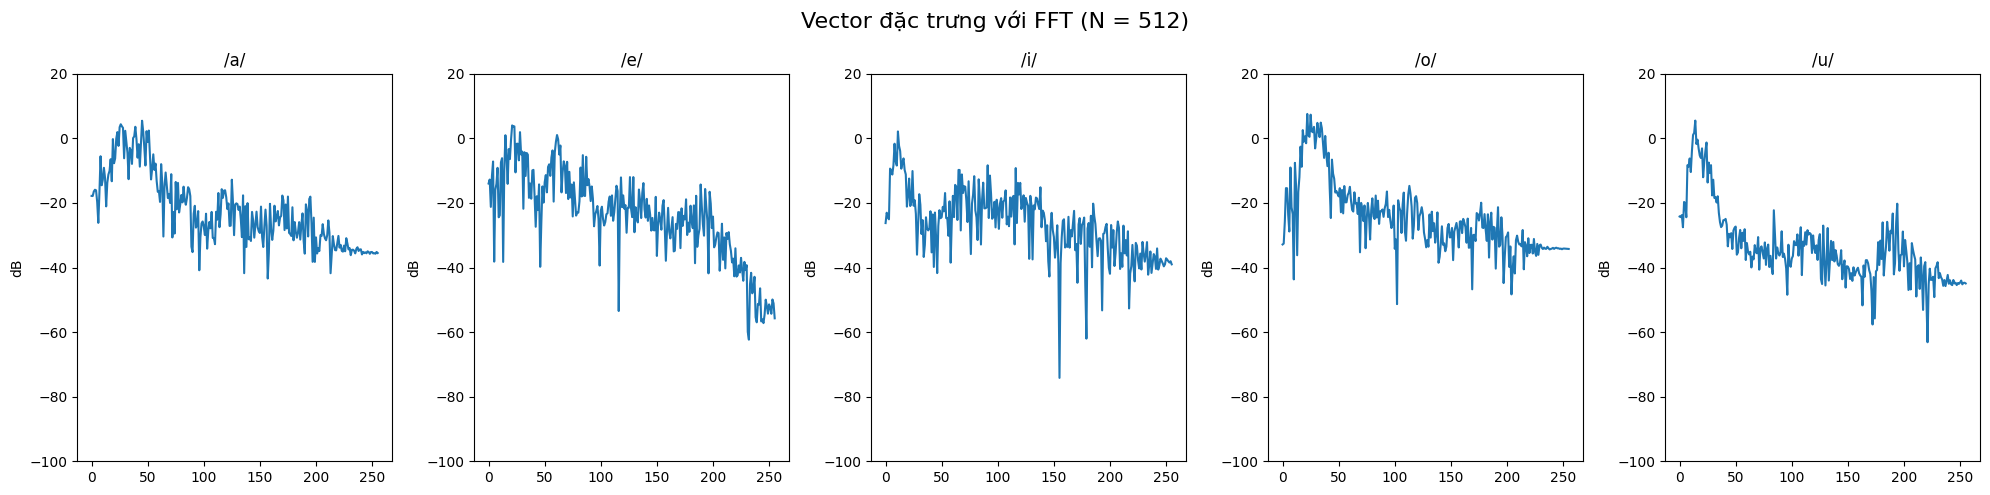

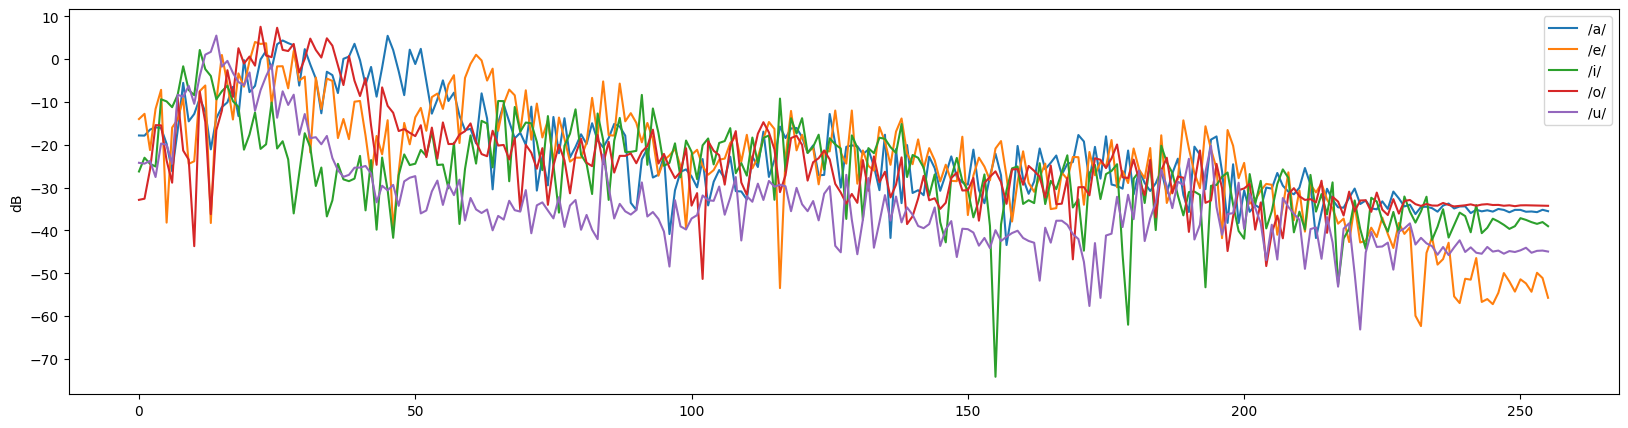

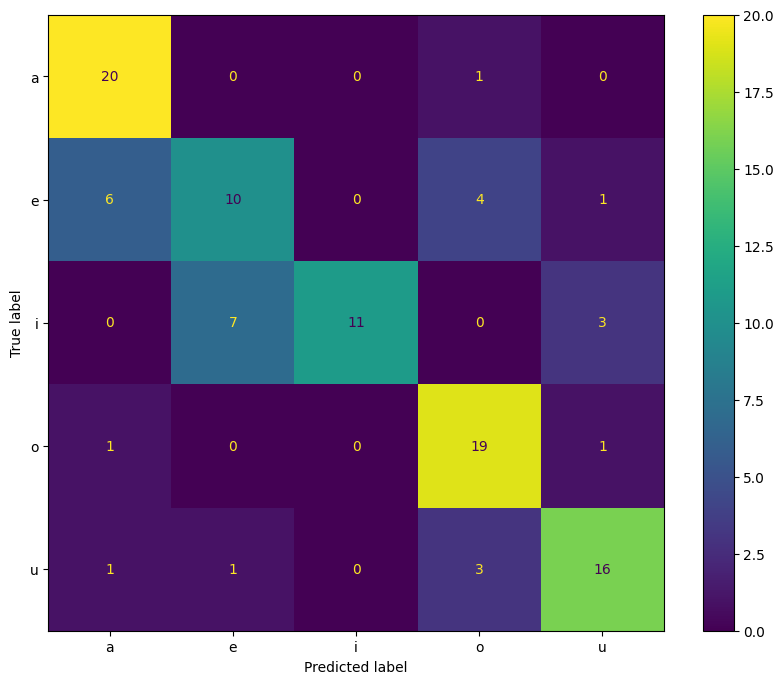

              precision    recall  f1-score   support

           a       0.95      0.86      0.90        21
           e       0.64      0.86      0.73        21
           i       0.79      0.71      0.75        21
           o       0.86      0.90      0.88        21
           u       0.88      0.71      0.79        21

    accuracy                           0.81       105
   macro avg       0.83      0.81      0.81       105
weighted avg       0.83      0.81      0.81       105

0.8095238095238095


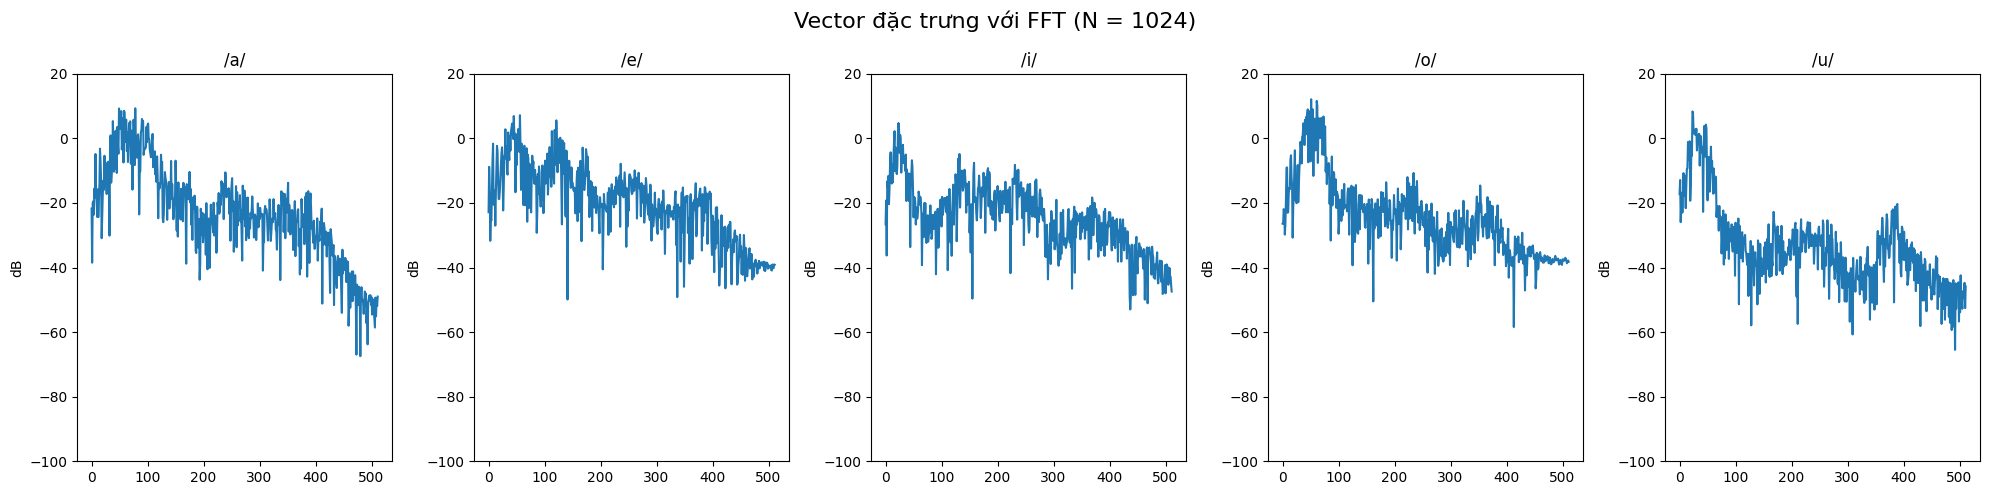

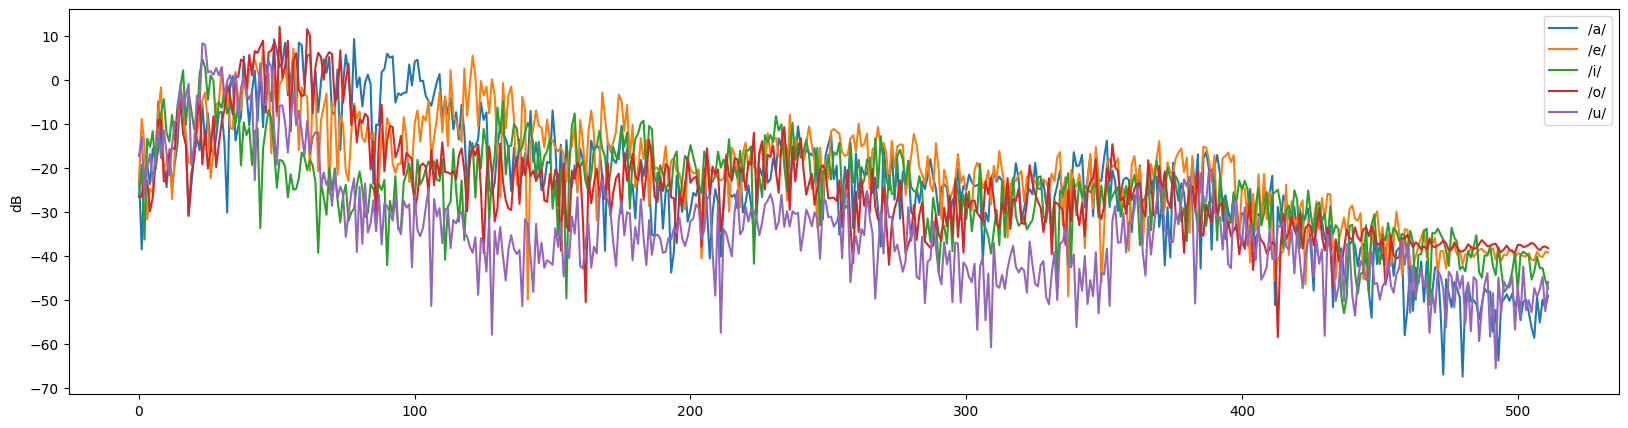

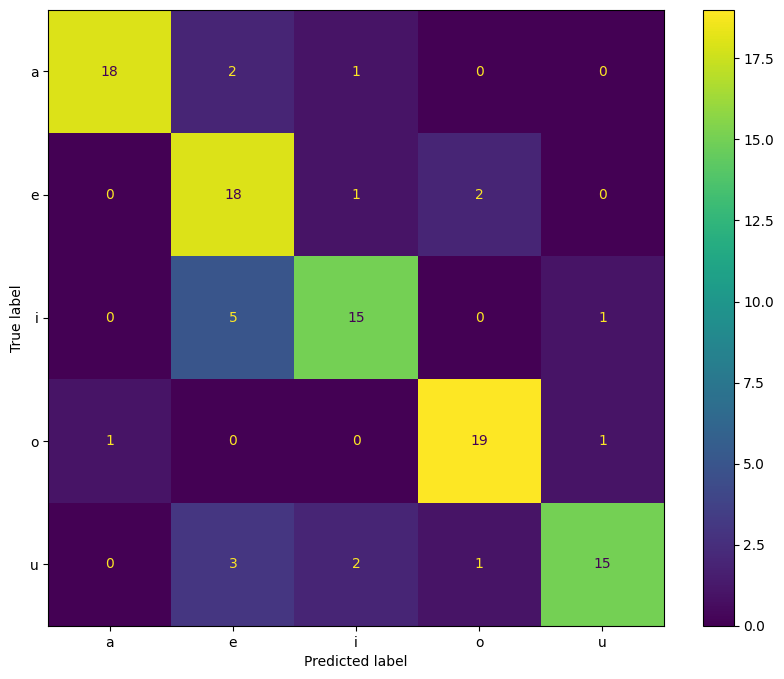

              precision    recall  f1-score   support

           a       0.86      0.90      0.88        21
           e       0.70      0.90      0.79        21
           i       0.83      0.71      0.77        21
           o       0.86      0.86      0.86        21
           u       0.94      0.76      0.84        21

    accuracy                           0.83       105
   macro avg       0.84      0.83      0.83       105
weighted avg       0.84      0.83      0.83       105

0.8285714285714286


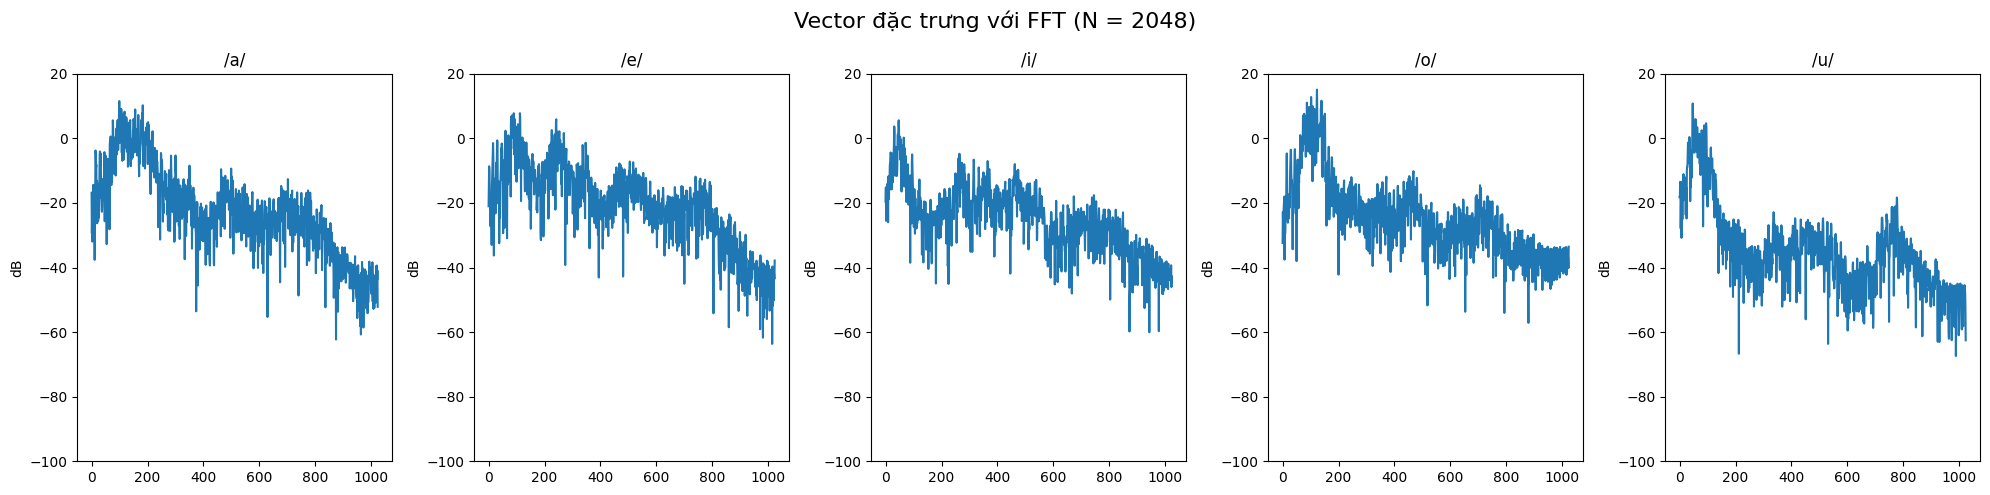

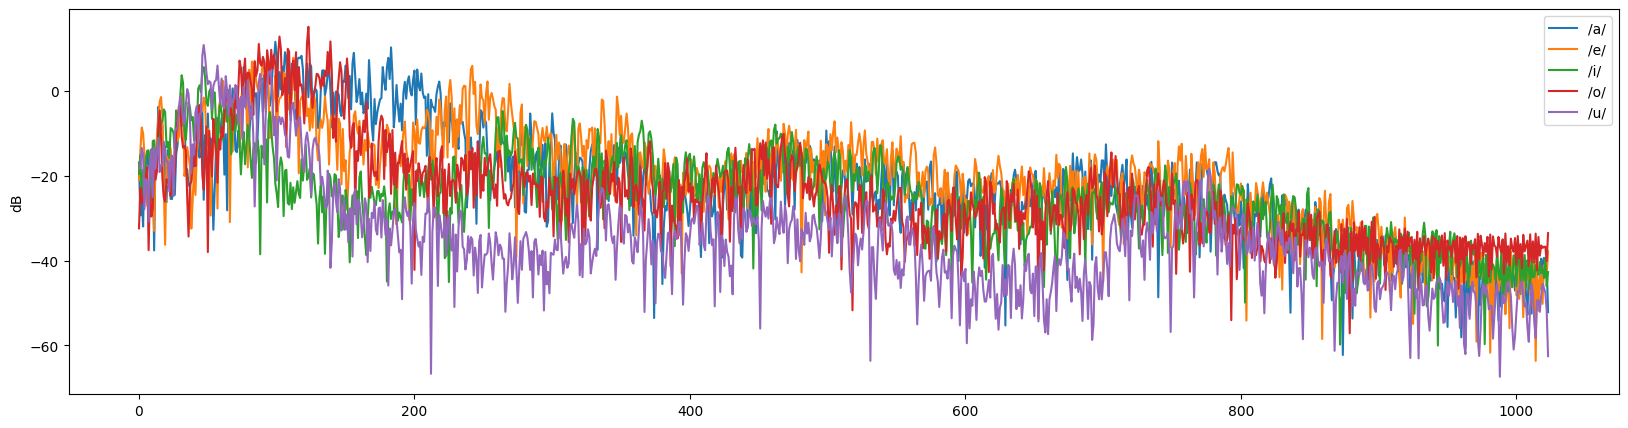

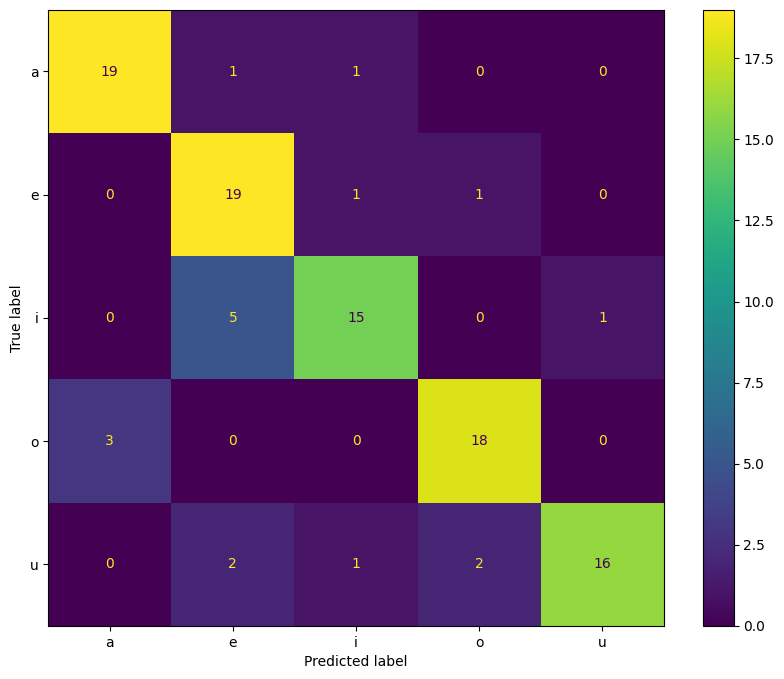

In [16]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import glob



config = {
  "train_path":"signals/NguyenAmHuanLuyen-16k",
  "valid_path":"signals/NguyenAmKiemThu-16k",
  "nffts": [512, 1024, 2048],
  "am": ["a", "e", "i", "o", "u"]
}

def SingleFrameFFT(frame, nFFT):
   return np.fft.fft(frame,nFFT)


def getFeaturesVector(file_path, nFFT):

  # ==== get label =====================
  filename = os.path.basename(file_path)
  # ====================================

  # === get human say ==================
  human = file_path.split("/")[-2]
  # ====================================

  # Load audio file
  y, fs = librosa.load(file_path, sr = None)

  # Calculate Short-Time Energy (STE)
  window_size = 0.03  # Size of the window (30 ms)
  overlap = 0.0  # Overlap between windows (50%)
  ste_threshold = 0.01  # STE threshold for classifying sound and silence

  # Calculate window parameters
  window_length = int(window_size * fs)
  overlap_length = int(overlap * window_length)

  # Calculate STE for each window
  ste = np.zeros_like(y)
  for i in range(0, len(y) - window_length, window_length - overlap_length):
      window = y[i:i + window_length]
      ste[i:i + window_length] = np.sum(window ** 2)

  # Classify sound and silence
  sound_segments = y[ste > ste_threshold]
  silence_segments = y[ste <= ste_threshold]

  # Create time vectors
  time_sound = np.arange(len(sound_segments)) / fs
  time_silence = np.arange(len(silence_segments)) / fs

  # ==========================
  offset = sound_segments.shape[0]
  x1 = sound_segments[int(offset * 1/3): int(offset * 2/3)]
  t = time_sound[int(offset * 1/3): int(offset * 2/3)]
  time_step = 0.03 # = 30ms
  # m = len(np.arange(t[0], t[-1], time_step))
  m = 2

  features = np.zeros(nFFT, dtype=np.complex128)
  for (i) in range(m):
    frame = x1[int(x1.shape[0] * i/m ): int(x1.shape[0] * (i + 1)/m)]
    features += SingleFrameFFT(frame, nFFT = nFFT)

  return features / m

def euclidean_distance(a, b):
    return abs(a - b)

for NFFT in config["nffts"]:
  m = {
    "a":np.zeros(NFFT, dtype=np.complex128),
    "e":np.zeros(NFFT, dtype=np.complex128),
    "i":np.zeros(NFFT, dtype=np.complex128),
    "o":np.zeros(NFFT, dtype=np.complex128),
    "u":np.zeros(NFFT, dtype=np.complex128),
  }

  for path in glob.glob(config["train_path"] + "/**/*.wav"):
    label = os.path.basename(path).split(".")[0]
    features = getFeaturesVector(path, nFFT = NFFT)
    m[label] += features

  for a in config["am"]:
    m[a] /= len(os.listdir(config["train_path"]))

  y_true = []
  y_pred = []

  for fname in glob.glob(config["valid_path"] + "/**/*.wav"):
    label = os.path.basename(fname).split(".")[0]
    yhat = getFeaturesVector(fname, nFFT = NFFT)
    pred = []
    for a in config["am"]:
      s = 0
      for (i) in range(NFFT):
        s += euclidean_distance(abs(m[a][i]), abs(yhat[i]))
      pred.append(s)

    y_pred.append(config["am"][np.argmin(pred)])
    y_true.append(label)

  plt.rcParams["figure.figsize"] = (20, 5)

  from matplotlib import cm
  fig, axs = plt.subplots(1, 5)
  fig.figsize = (20,30)
  fig.suptitle("Vector đặc trưng với FFT (N = {})".format(NFFT), fontsize=16)
  for i in range(len(config["am"])):
    axs[i].set_title("/"+config["am"][i]+"/")
    axs[i].plot(20*np.log10(abs(m[config["am"][i]][:len(m[config["am"][i]])//2])))
    axs[i].set_ylim([-100, 20])
    axs[i].set_ylabel("dB")

  fig.tight_layout()
  fig.show()

  fig, axs = plt.subplots(1)
  for a in config["am"]:
    axs.plot(20*np.log10(abs(m[a][:len(m[a])//2])), label = "/"+a+"/")

  axs.set_ylabel("dB")
  axs.legend()
  fig.show()

  from sklearn.metrics import classification_report, accuracy_score
  print(classification_report(y_true, y_pred))
  print(accuracy_score(y_true, y_pred))

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  cm = confusion_matrix(y_true, y_pred, labels=config["am"])

  plt.rcParams["figure.figsize"] = (10, 8)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config["am"])
  disp.plot()
  plt.show()

# Bài 3 - MFCC (Only)

              precision    recall  f1-score   support

           a       0.90      0.90      0.90        21
           e       0.95      0.86      0.90        21
           i       1.00      0.86      0.92        21
           o       0.90      0.90      0.90        21
           u       0.81      1.00      0.89        21

    accuracy                           0.90       105
   macro avg       0.91      0.90      0.91       105
weighted avg       0.91      0.90      0.91       105

0.9047619047619048


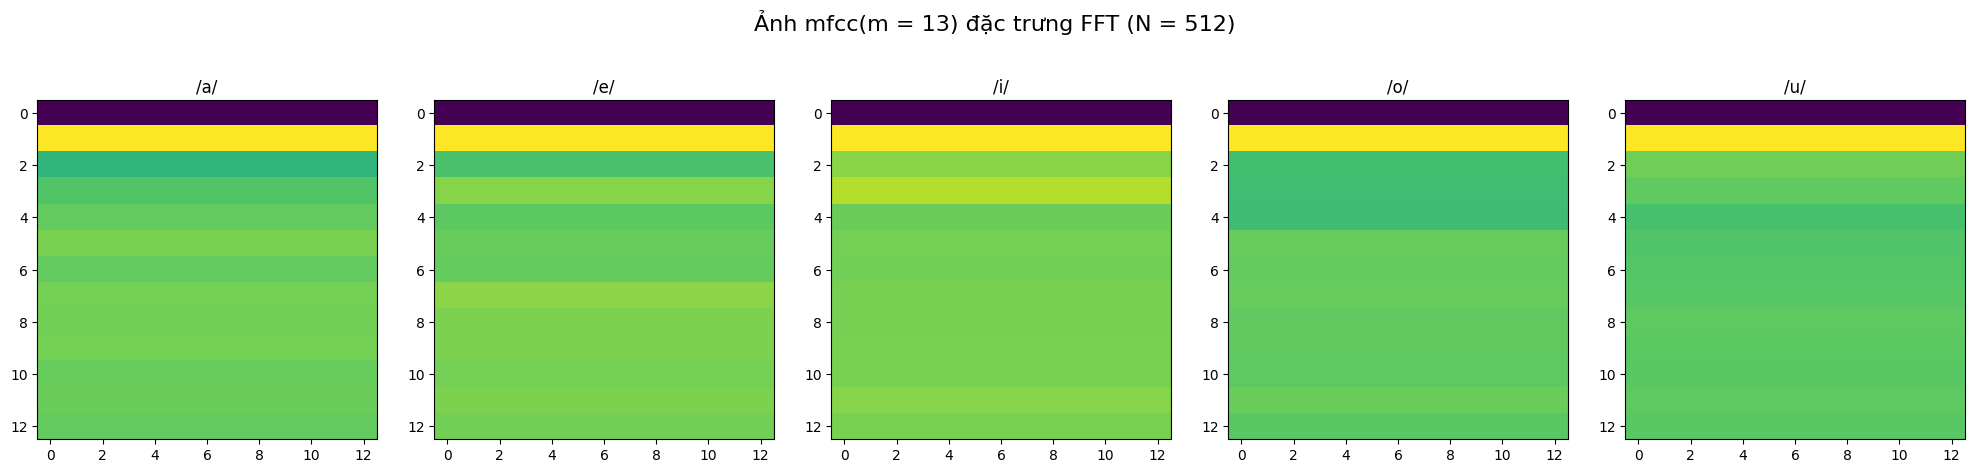

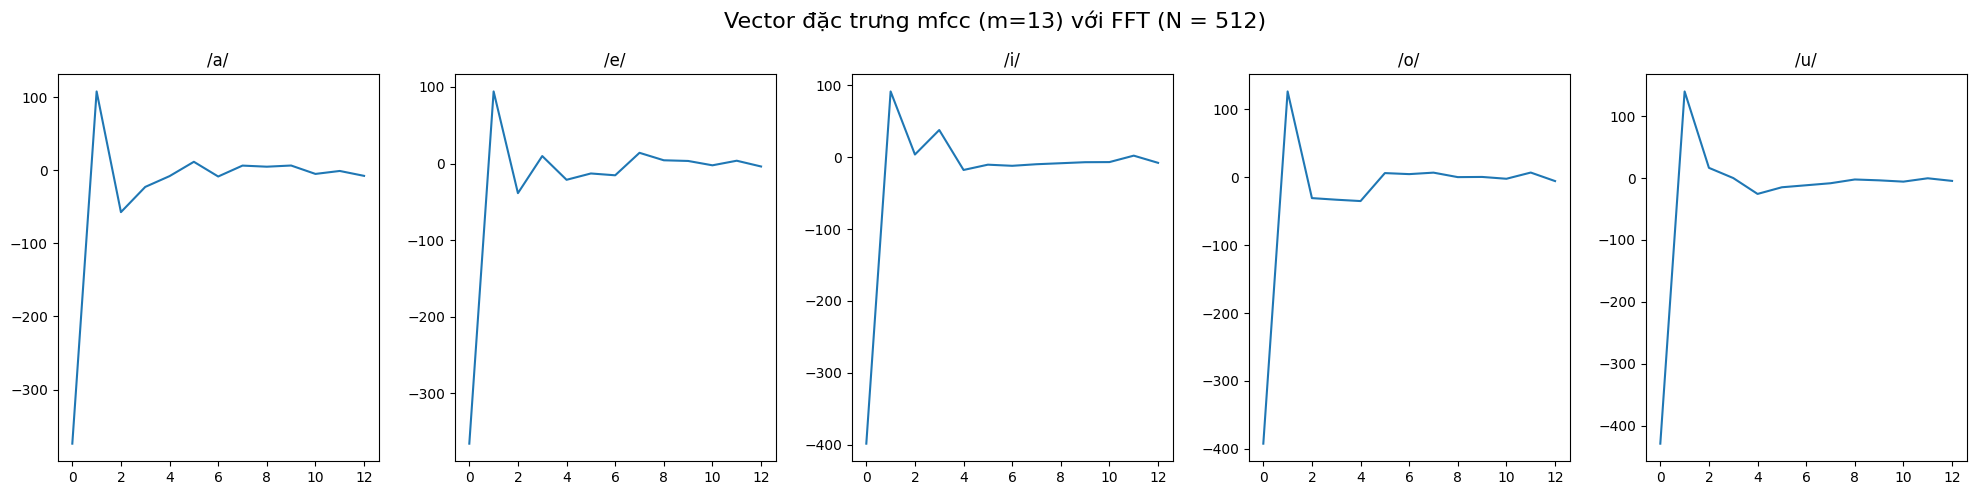

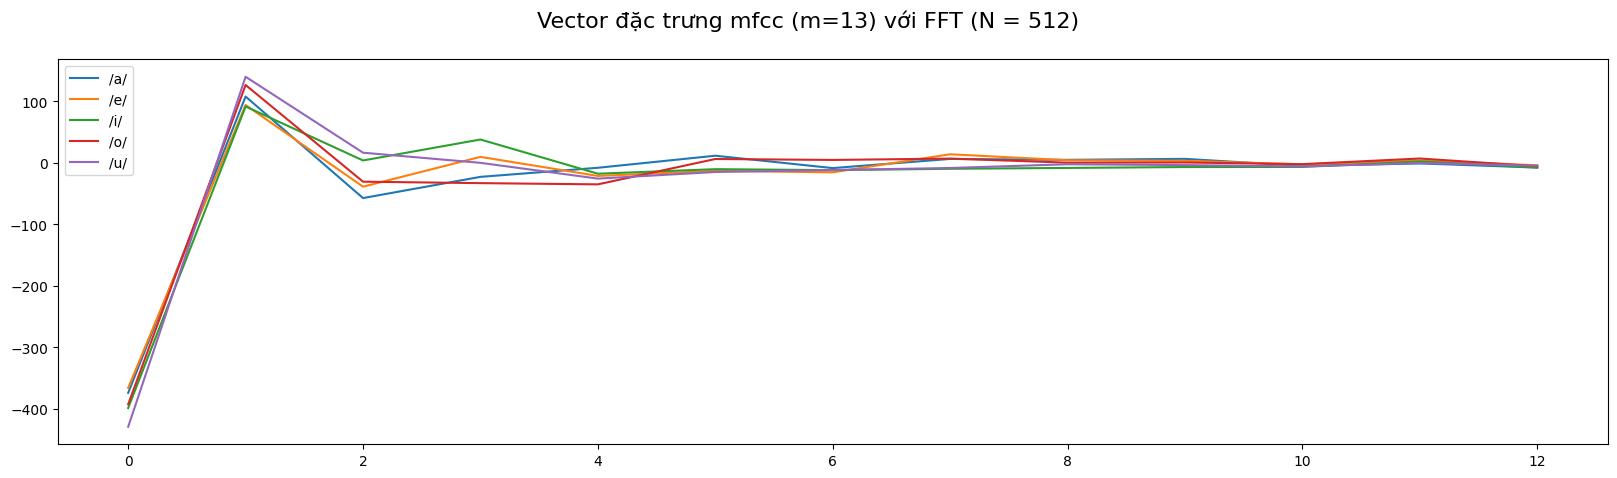

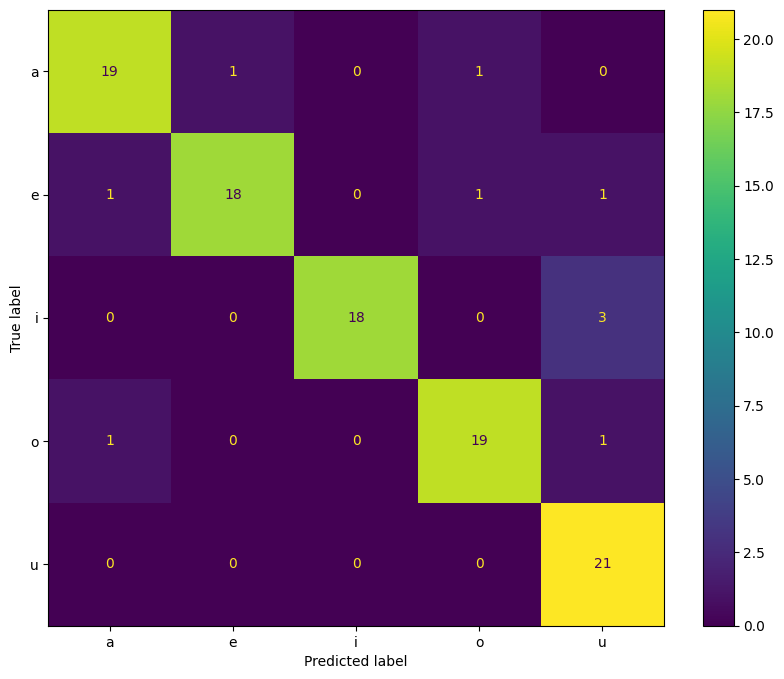

              precision    recall  f1-score   support

           a       0.90      0.90      0.90        21
           e       0.86      0.86      0.86        21
           i       1.00      0.81      0.89        21
           o       0.95      0.90      0.93        21
           u       0.81      1.00      0.89        21

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105

0.8952380952380953


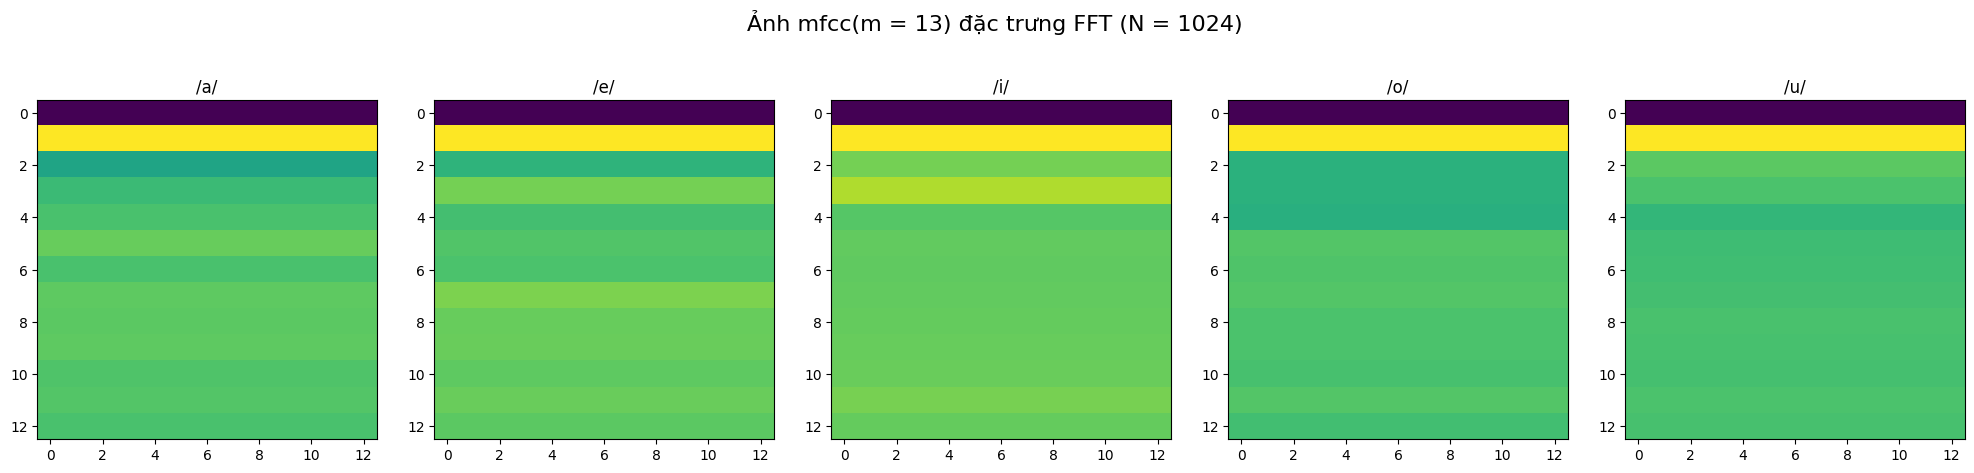

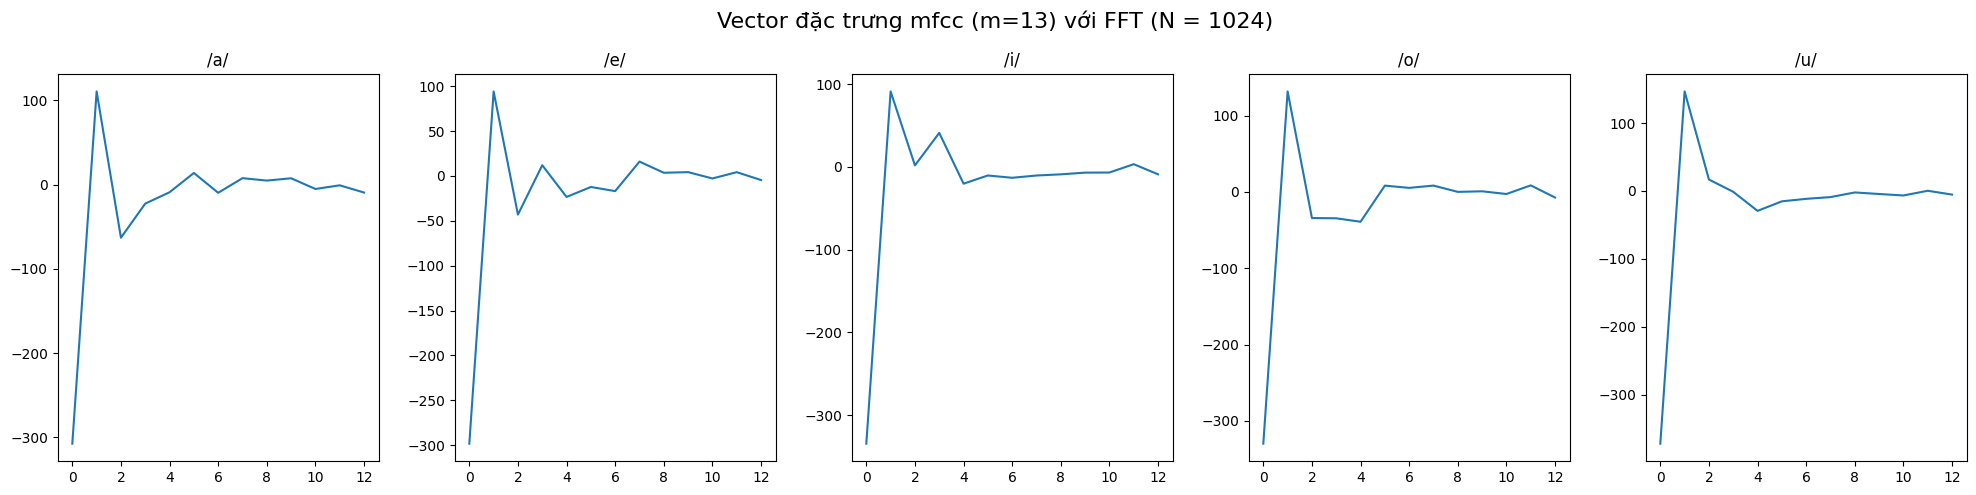

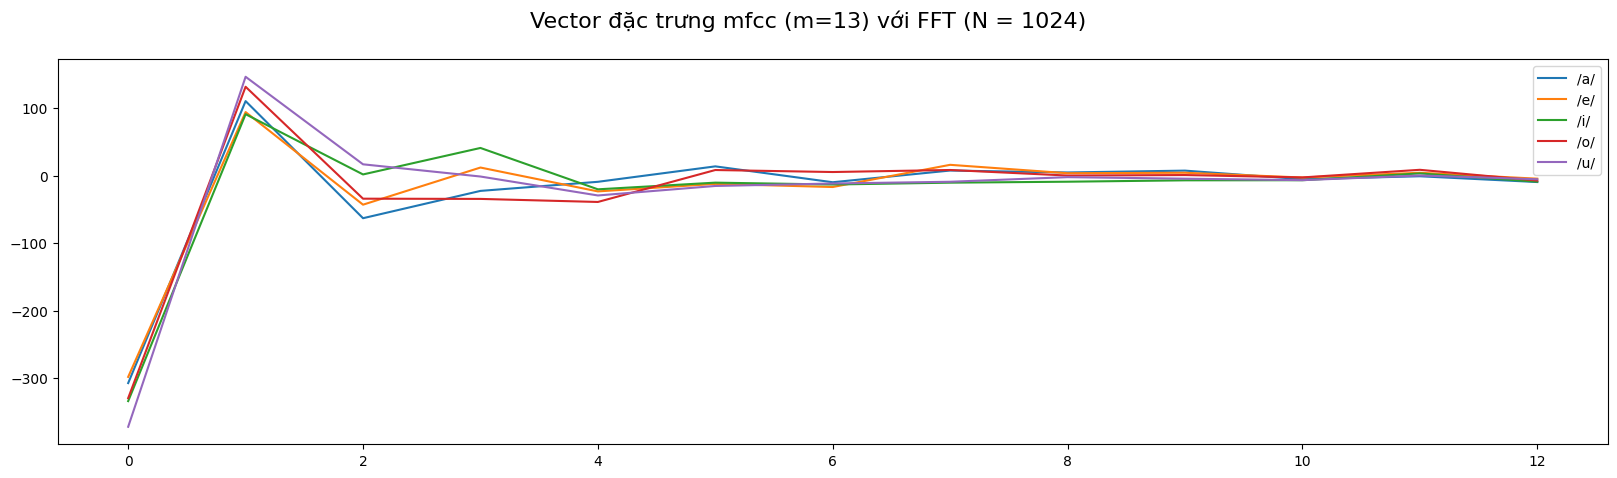

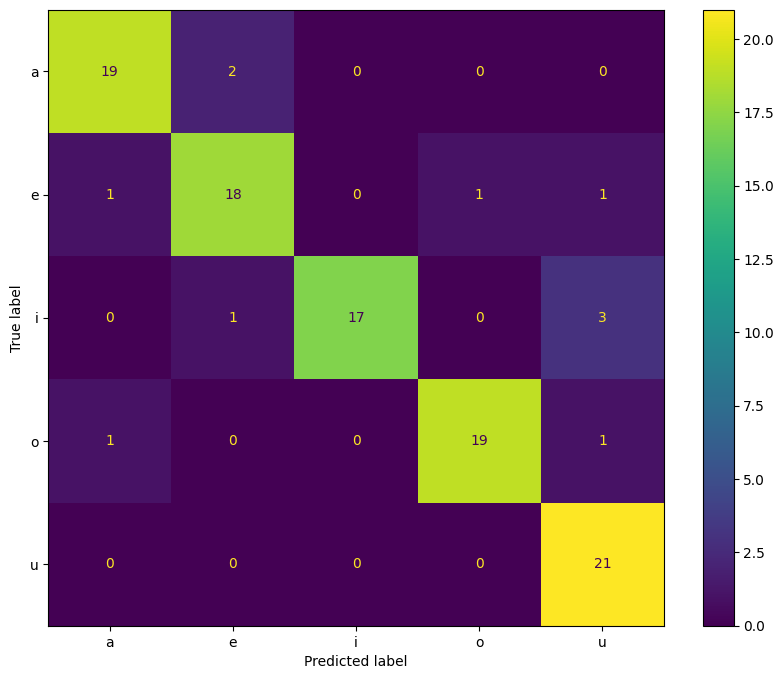

              precision    recall  f1-score   support

           a       0.90      0.90      0.90        21
           e       0.82      0.86      0.84        21
           i       1.00      0.76      0.86        21
           o       0.95      0.90      0.93        21
           u       0.81      1.00      0.89        21

    accuracy                           0.89       105
   macro avg       0.90      0.89      0.89       105
weighted avg       0.90      0.89      0.89       105

0.8857142857142857


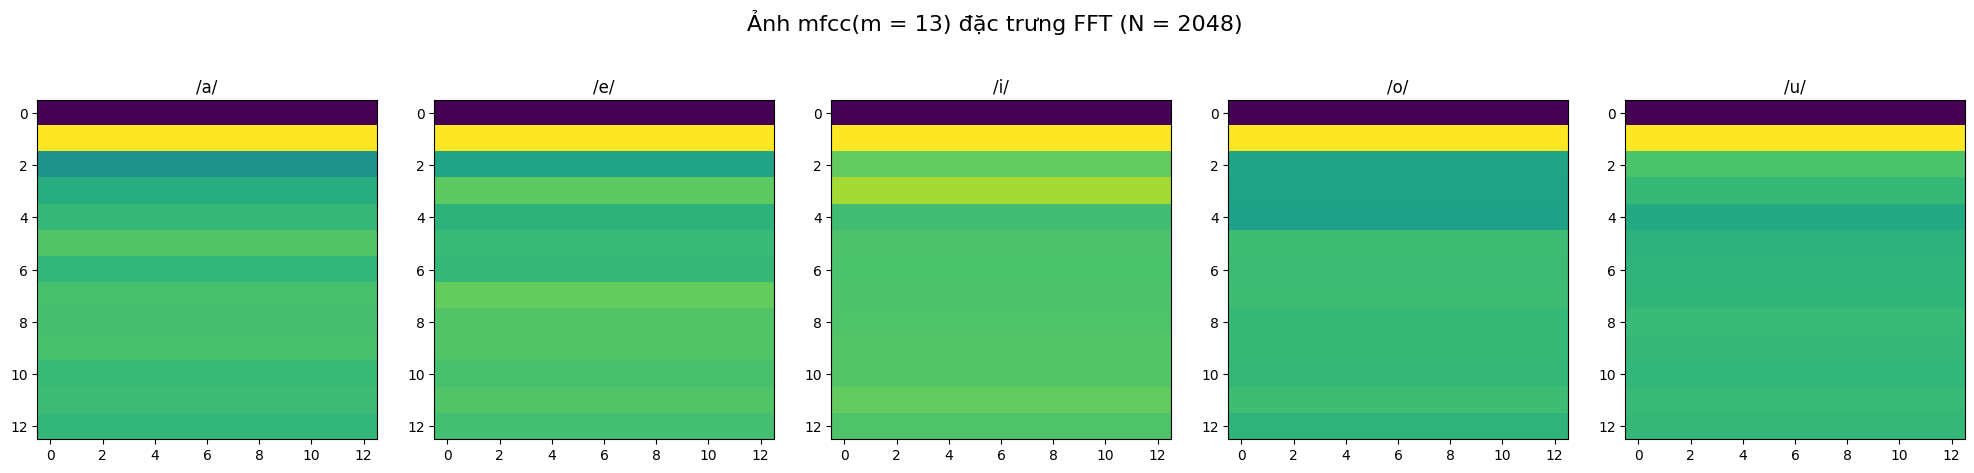

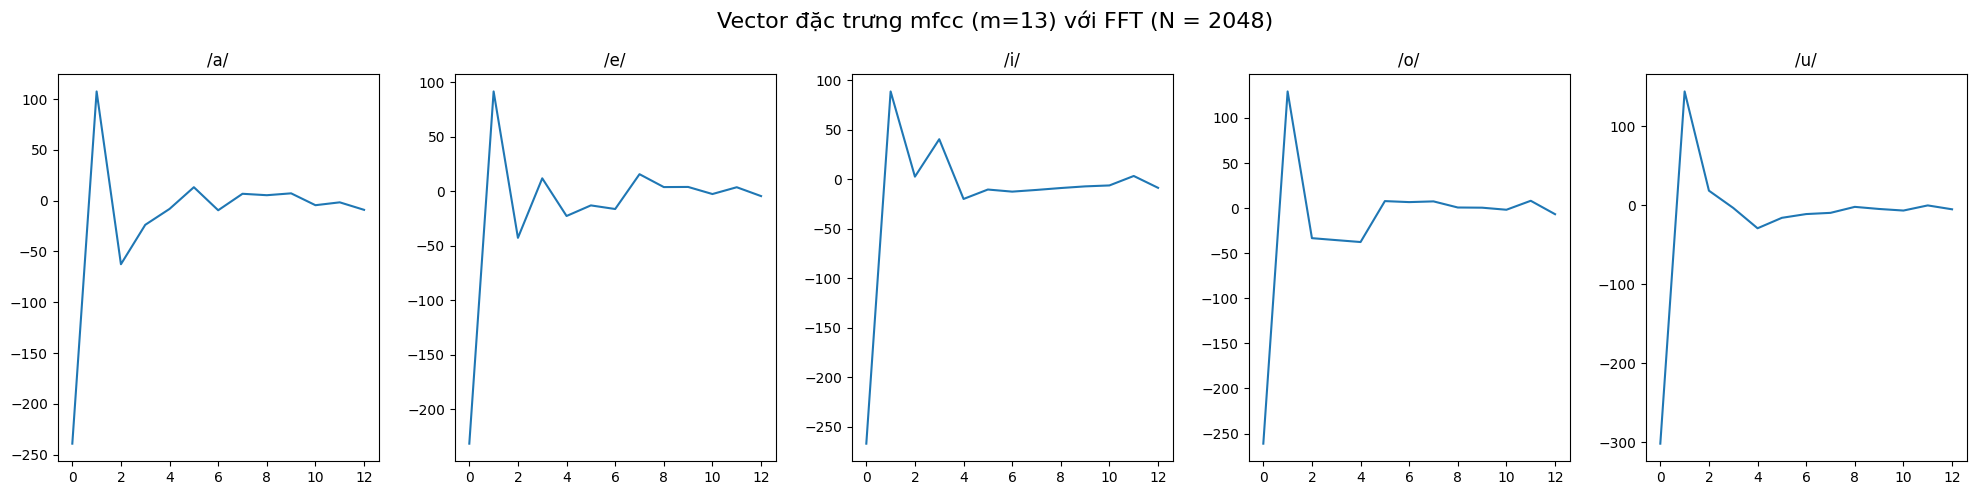

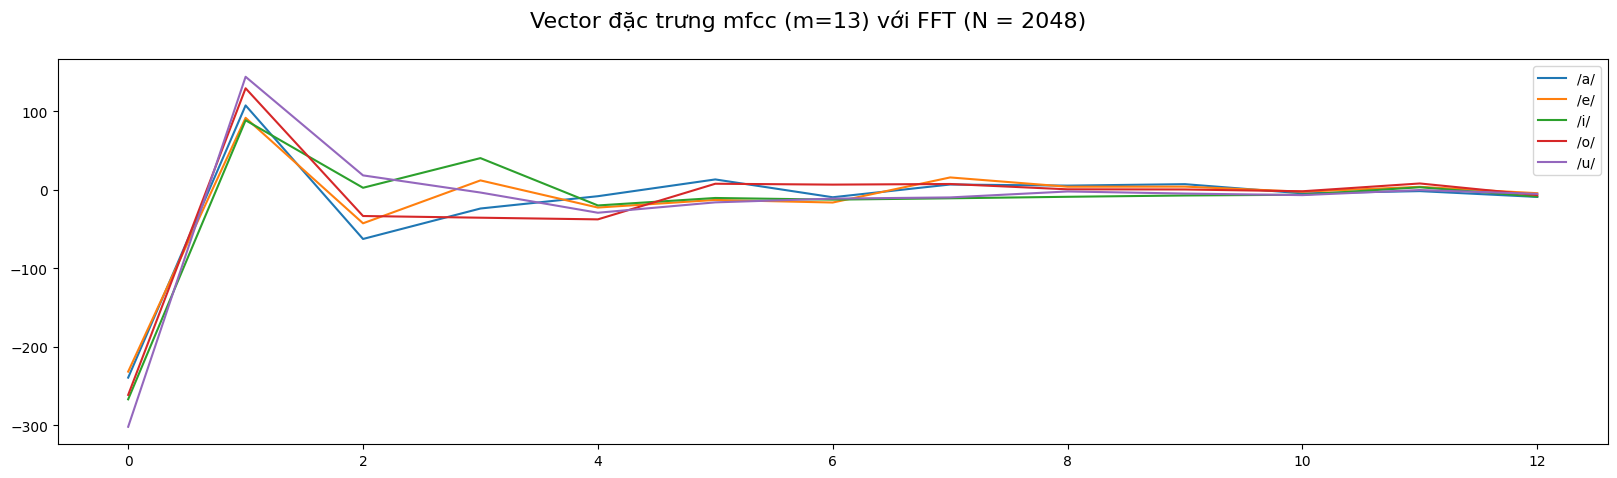

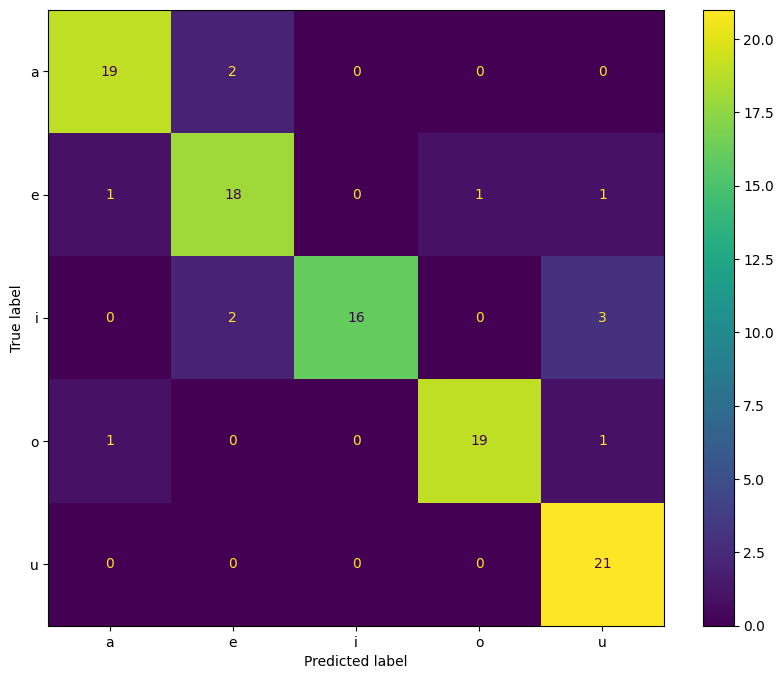

In [17]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import glob

config = {
  "train_path":"signals/NguyenAmHuanLuyen-16k",
  "valid_path":"signals/NguyenAmKiemThu-16k",
  "nffts": [512, 1024, 2048],
  "am": ["a", "e", "i", "o", "u"],
  "mfcc": 13
}

def euclidean_distance(a, b):
    return abs(a - b)

def load_audio(filename):
    try:
        return librosa.load(filename, sr=None)
    except Exception as e:
        print(f"Cannot load '{filename}': {e}")
        return None

def extract_mfcc(y, sr=22050, n_mfcc=10, n_fft=1024):
    try:
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    except Exception as e:
        print(f"Cannot extract MFCC: {e}")
        return None

def getFeaturesVector(file_path, n_mfcc = 13, n_fft=1024):
  # ==== get label =====================
  filename = os.path.basename(file_path)
  # ====================================

  # === get human say ==================
  human = file_path.split("/")[-2]
  # ====================================

  # Load audio file
  y, fs = librosa.load(file_path, sr=None)

  # Calculate Short-Time Energy (STE)
  window_size = 0.03  # Size of the window (30 ms)
  overlap = 0.5  # Overlap between windows (50%)
  ste_threshold = 0.01  # STE threshold for classifying sound and silence

  # Calculate window parameters
  window_length = int(window_size * fs)
  overlap_length = int(overlap * window_length)

  # Calculate STE for each window
  ste = np.zeros_like(y)
  for i in range(0, len(y) - window_length, window_length - overlap_length):
      window = y[i:i + window_length]
      ste[i:i + window_length] = np.sum(window ** 2)

  # Classify sound and silence
  sound_segments = y[ste > ste_threshold]
  silence_segments = y[ste <= ste_threshold]

  # Create time vectors
  time_sound = np.arange(len(sound_segments)) / fs
  time_silence = np.arange(len(silence_segments)) / fs

  # ==========================
  offset = sound_segments.shape[0]
  # x1 = sound_segments[int(offset * 1/3): int(offset * 2/3)]
  x1 = sound_segments
  # t = time_sound[int(offset * 1/3): int(offset * 2/3)]
  t = time_sound
  time_step = 0.03 # = 30ms
  m = len(np.arange(t[0], t[-1], time_step))

  features = np.zeros((n_mfcc, n_mfcc))
  for (i) in range(m):
    frame = x1[int(x1.shape[0] * i/m ): int(x1.shape[0] * (i + 1)/m)]
    features += extract_mfcc(frame, fs, n_mfcc, n_fft)
  return features / m

for n_fft in config["nffts"]:
  m = {
    "a":np.zeros((config["mfcc"], config["mfcc"])),
    "e":np.zeros((config["mfcc"], config["mfcc"])),
    "i":np.zeros((config["mfcc"], config["mfcc"])),
    "o":np.zeros((config["mfcc"], config["mfcc"])),
    "u":np.zeros((config["mfcc"], config["mfcc"])),
  }

  for path in glob.glob(config["train_path"] + "/**/*.wav"):
    label = os.path.basename(path).split(".")[0]
    fmc = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft=n_fft)
    m[label] += fmc

  for a in config["am"]:
    m[a] /= len(os.listdir(config["train_path"]))

  y_true = []
  y_pred = []

  for fname in glob.glob(config["valid_path"] + "/**/*.wav"):
    label = os.path.basename(fname).split(".")[0]
    yhat = getFeaturesVector(fname, n_mfcc=config["mfcc"], n_fft=n_fft)
    pred = []
    for a in config["am"]:
      s = 0
      for (i) in range(config["mfcc"]):
        for(j) in range(config["mfcc"]):
          s += euclidean_distance(m[a][i][j], yhat[i][j])
      pred.append(s)

    y_pred.append(config["am"][np.argmin(pred)])
    y_true.append(label)

  plt.rcParams["figure.figsize"] = (20, 5)
  from matplotlib import cm
  fig, axs = plt.subplots(1, 5)
  fig.figsize = (20,30)
  fig.suptitle("Ảnh mfcc(m = {}) đặc trưng FFT (N = {})".format(config["mfcc"],n_fft), fontsize=16)
  axs[0].set_title("/a/")
  axs[0].imshow(m["a"])

  axs[1].set_title("/e/")
  axs[1].imshow(m["e"])

  axs[2].set_title("/i/")
  axs[2].imshow(m["i"])

  axs[3].set_title("/o/")
  axs[3].imshow(m["o"])

  axs[4].set_title("/u/")
  axs[4].imshow(m["u"])
  fig.tight_layout()
  fig.show()

  #==========================
  fig, axs = plt.subplots(1, 5)
  fig.figsize = (20,30)
  fig.suptitle("Vector đặc trưng mfcc (m={}) với FFT (N = {})".format(config["mfcc"], n_fft), fontsize=16)
  axs[0].set_title("/a/")
  axs[0].plot(m["a"][:, 0])

  axs[1].set_title("/e/")
  axs[1].plot(m["e"][:, 0])

  axs[2].set_title("/i/")
  axs[2].plot(m["i"][:, 0])

  axs[3].set_title("/o/")
  axs[3].plot(m["o"][:, 0])

  axs[4].set_title("/u/")
  axs[4].plot(m["u"][:, 0])

  fig.tight_layout()
  fig.show()

  # ==========================
  fig, axs = plt.subplots(1)
  fig.suptitle("Vector đặc trưng mfcc (m={}) với FFT (N = {})".format(config["mfcc"], n_fft), fontsize=16)
  axs.plot(m["a"][:, 0], label = "/a/")
  axs.plot(m["e"][:, 0], label = "/e/")
  axs.plot(m["i"][:, 0], label = "/i/")
  axs.plot(m["o"][:, 0], label = "/o/")
  axs.plot(m["u"][:, 0], label = "/u/")
  axs.legend()
  fig.show()

  from sklearn.metrics import classification_report, accuracy_score
  print(classification_report(y_true, y_pred))
  print(accuracy_score(y_true, y_pred))

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  cm = confusion_matrix(y_true, y_pred, labels=config["am"])

  plt.rcParams["figure.figsize"] = (10, 8)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config["am"])
  disp.plot()
  plt.show()

# Bài 3 - MFCC (with K-means)

n_fft  =  512  K =  2
              precision    recall  f1-score   support

           a       0.83      0.95      0.89        21
           e       0.90      0.86      0.88        21
           i       0.90      0.90      0.90        21
           o       0.90      0.86      0.88        21
           u       0.95      0.90      0.93        21

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105

0.8952380952380953


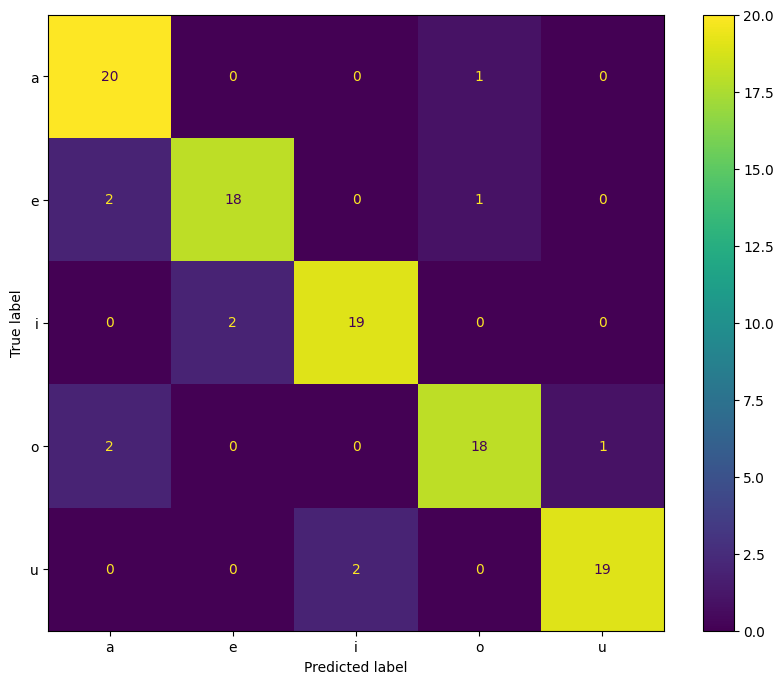

n_fft  =  1024  K =  2
              precision    recall  f1-score   support

           a       0.86      0.90      0.88        21
           e       0.86      0.86      0.86        21
           i       0.90      0.90      0.90        21
           o       0.90      0.86      0.88        21
           u       0.90      0.90      0.90        21

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.89       105
weighted avg       0.89      0.89      0.89       105

0.8857142857142857


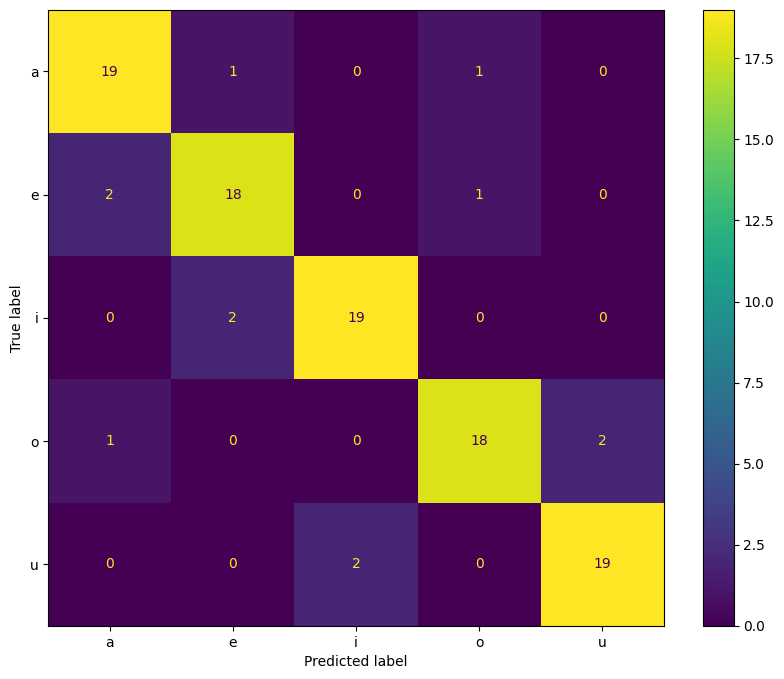

n_fft  =  2048  K =  2
              precision    recall  f1-score   support

           a       0.86      0.90      0.88        21
           e       0.72      0.86      0.78        21
           i       0.89      0.76      0.82        21
           o       0.95      0.90      0.93        21
           u       0.95      0.90      0.93        21

    accuracy                           0.87       105
   macro avg       0.87      0.87      0.87       105
weighted avg       0.87      0.87      0.87       105

0.8666666666666667


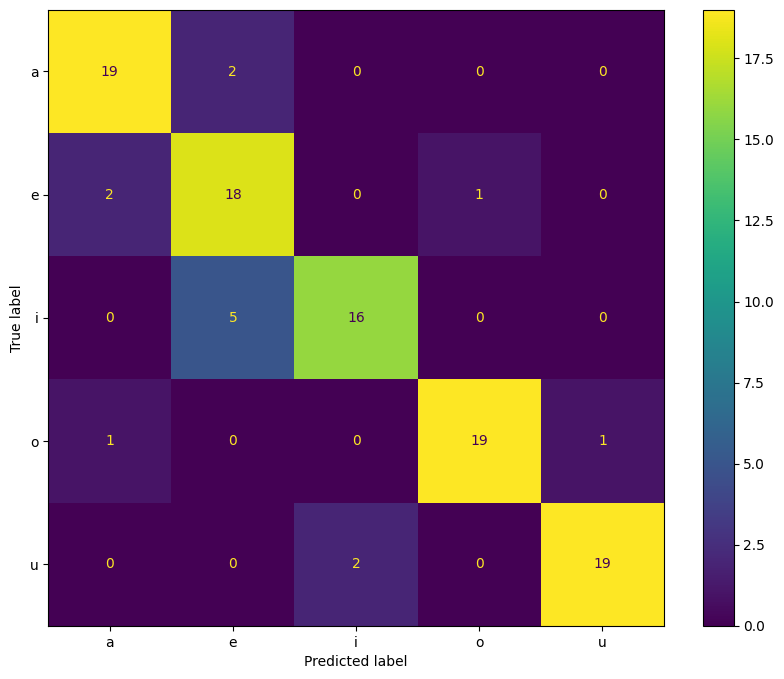

n_fft  =  512  K =  3
              precision    recall  f1-score   support

           a       0.91      0.95      0.93        21
           e       0.90      0.86      0.88        21
           i       0.90      0.90      0.90        21
           o       0.95      0.95      0.95        21
           u       0.90      0.90      0.90        21

    accuracy                           0.91       105
   macro avg       0.91      0.91      0.91       105
weighted avg       0.91      0.91      0.91       105

0.9142857142857143


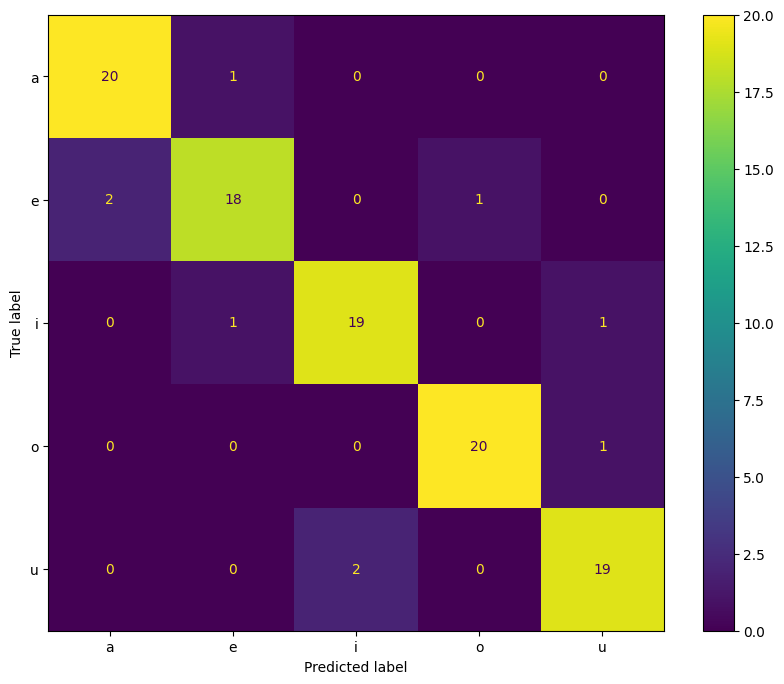

n_fft  =  1024  K =  3
              precision    recall  f1-score   support

           a       0.86      0.90      0.88        21
           e       0.77      0.81      0.79        21
           i       0.90      0.86      0.88        21
           o       0.95      0.95      0.95        21
           u       0.95      0.90      0.93        21

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.89       105
weighted avg       0.89      0.89      0.89       105

0.8857142857142857


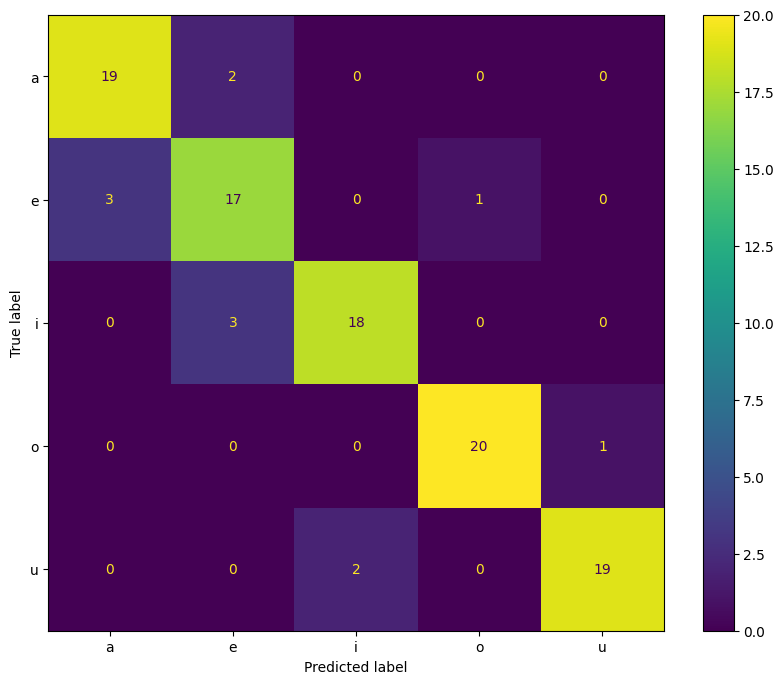

n_fft  =  2048  K =  3
              precision    recall  f1-score   support

           a       0.86      0.90      0.88        21
           e       0.74      0.81      0.77        21
           i       0.89      0.76      0.82        21
           o       0.95      0.95      0.95        21
           u       0.90      0.90      0.90        21

    accuracy                           0.87       105
   macro avg       0.87      0.87      0.87       105
weighted avg       0.87      0.87      0.87       105

0.8666666666666667


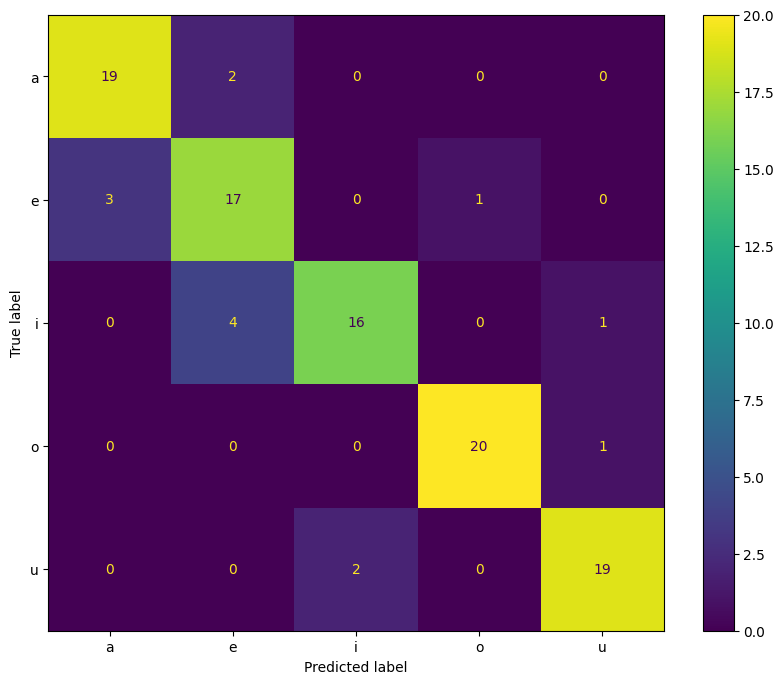

n_fft  =  512  K =  4
              precision    recall  f1-score   support

           a       0.95      0.86      0.90        21
           e       0.83      0.90      0.86        21
           i       0.90      0.90      0.90        21
           o       0.90      0.90      0.90        21
           u       0.90      0.90      0.90        21

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105

0.8952380952380953


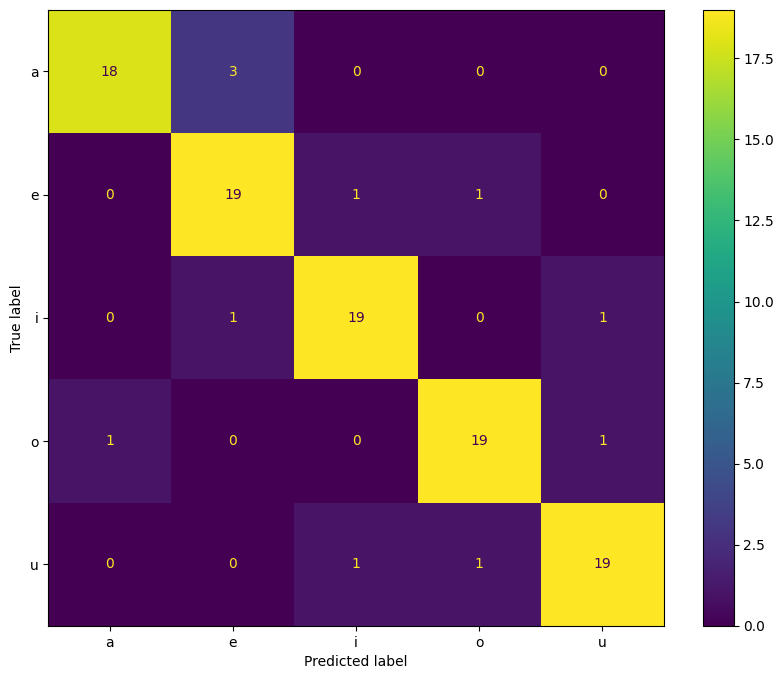

n_fft  =  1024  K =  4
              precision    recall  f1-score   support

           a       0.82      0.86      0.84        21
           e       0.76      0.90      0.83        21
           i       0.90      0.86      0.88        21
           o       1.00      0.86      0.92        21
           u       0.95      0.90      0.93        21

    accuracy                           0.88       105
   macro avg       0.89      0.88      0.88       105
weighted avg       0.89      0.88      0.88       105

0.8761904761904762


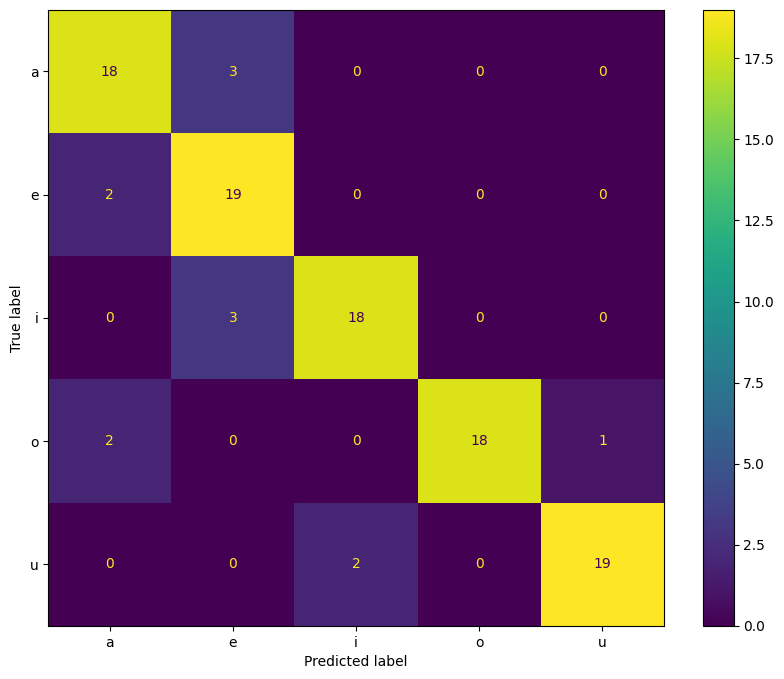

n_fft  =  2048  K =  4
              precision    recall  f1-score   support

           a       0.82      0.86      0.84        21
           e       0.79      0.90      0.84        21
           i       0.90      0.86      0.88        21
           o       1.00      0.86      0.92        21
           u       0.90      0.90      0.90        21

    accuracy                           0.88       105
   macro avg       0.88      0.88      0.88       105
weighted avg       0.88      0.88      0.88       105

0.8761904761904762


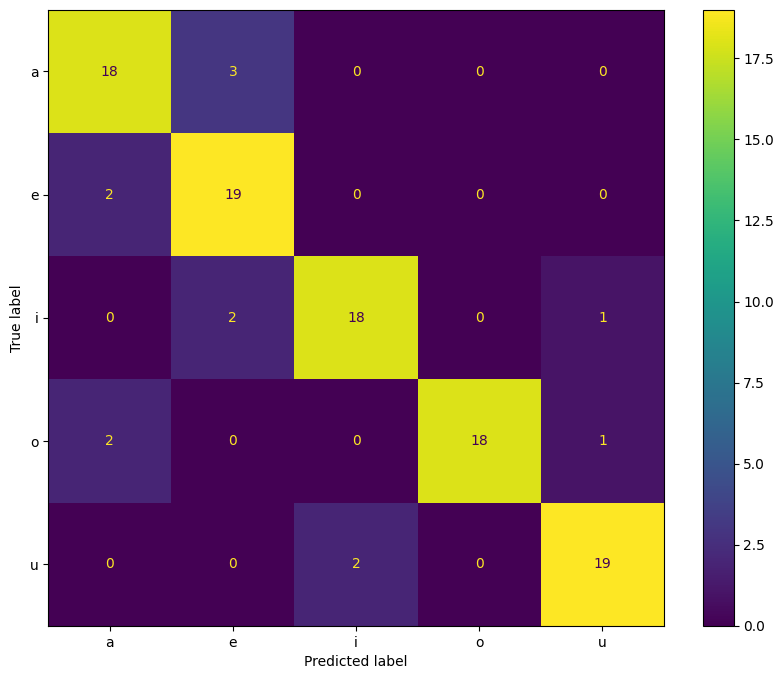

n_fft  =  512  K =  5
              precision    recall  f1-score   support

           a       0.95      0.86      0.90        21
           e       0.80      0.95      0.87        21
           i       0.89      0.81      0.85        21
           o       0.95      0.90      0.93        21
           u       0.86      0.90      0.88        21

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.89       105
weighted avg       0.89      0.89      0.89       105

0.8857142857142857


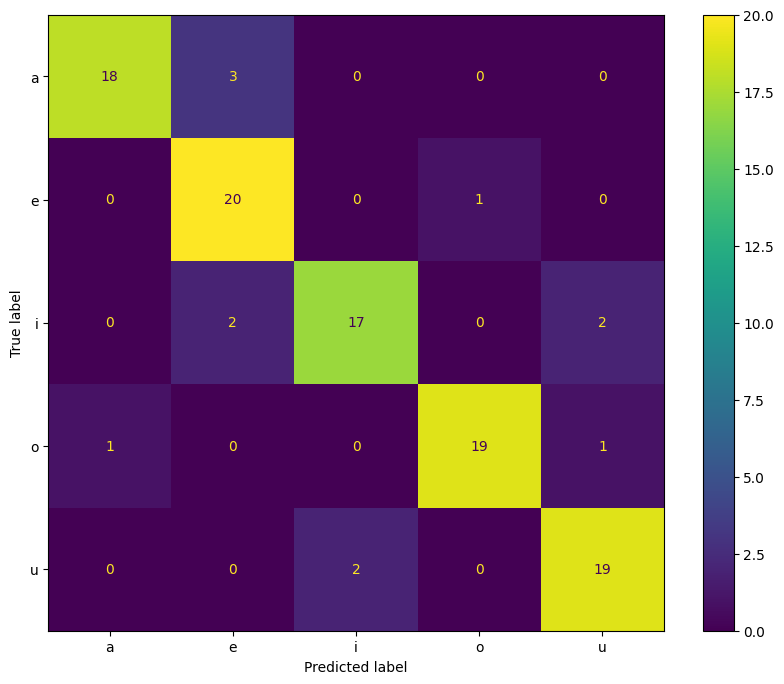

n_fft  =  1024  K =  5
              precision    recall  f1-score   support

           a       0.83      0.90      0.86        21
           e       0.86      0.90      0.88        21
           i       0.91      0.95      0.93        21
           o       0.94      0.81      0.87        21
           u       0.95      0.90      0.93        21

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105

0.8952380952380953


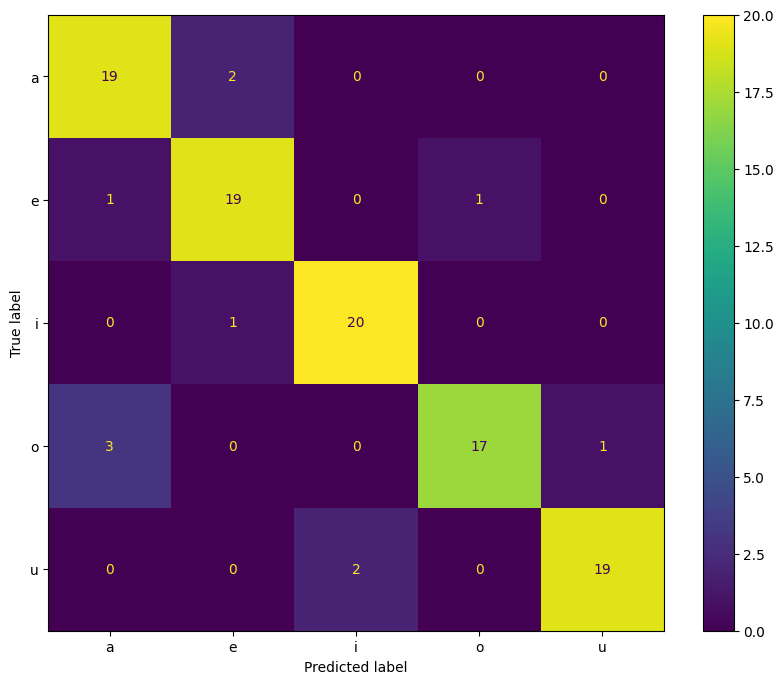

n_fft  =  2048  K =  5
              precision    recall  f1-score   support

           a       0.90      0.86      0.88        21
           e       0.79      0.90      0.84        21
           i       1.00      0.90      0.95        21
           o       0.95      0.90      0.93        21
           u       0.95      1.00      0.98        21

    accuracy                           0.91       105
   macro avg       0.92      0.91      0.92       105
weighted avg       0.92      0.91      0.92       105

0.9142857142857143


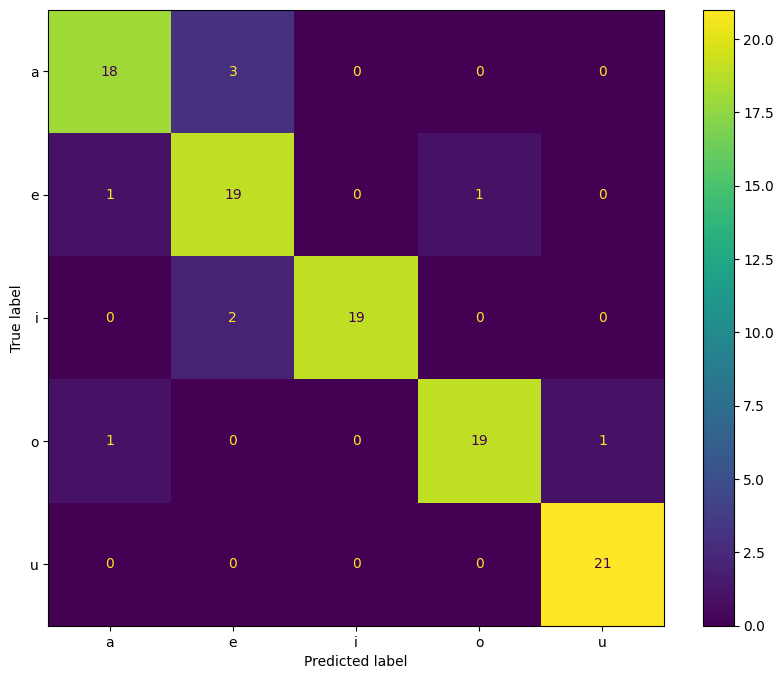

In [18]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans

config = {
    "train_path":"signals/NguyenAmHuanLuyen-16k",
    "valid_path":"signals/NguyenAmKiemThu-16k",
    "nffts": [512, 1024, 2048],
    "am": ["a", "e", "i", "o", "u"],
    "mfcc": 13,
    "K":[2, 3, 4, 5]
}

def euclidean_distance(a, b):
    return abs(a - b)

def load_audio(filename):
    try:
        return librosa.load(filename, sr=None)
    except Exception as e:
        print(f"Cannot load '{filename}': {e}")
        return None

def extract_mfcc(y, sr=22050, n_mfcc=10, n_fft=1024):
    try:
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    except Exception as e:
        print(f"Cannot extract MFCC: {e}")
        return None

def getFeaturesVector(file_path, n_mfcc = 13, n_fft=1024):
  # ==== get label =====================
  filename = os.path.basename(file_path)
  # ====================================

  # === get human say ==================
  human = file_path.split("/")[-2]
  # ====================================

  # Load audio file
  y, fs = librosa.load(file_path, sr=None)

  # Calculate Short-Time Energy (STE)
  window_size = 0.03  # Size of the window (30 ms)
  overlap = 0.5  # Overlap between windows (50%)
  ste_threshold = 0.01  # STE threshold for classifying sound and silence

  # Calculate window parameters
  window_length = int(window_size * fs)
  overlap_length = int(overlap * window_length)

  # Calculate STE for each window
  ste = np.zeros_like(y)
  for i in range(0, len(y) - window_length, window_length - overlap_length):
      window = y[i:i + window_length]
      ste[i:i + window_length] = np.sum(window ** 2)

  # Classify sound and silence
  sound_segments = y[ste > ste_threshold]
  silence_segments = y[ste <= ste_threshold]

  # Create time vectors
  time_sound = np.arange(len(sound_segments)) / fs
  time_silence = np.arange(len(silence_segments)) / fs

  # ==========================
  offset = sound_segments.shape[0]
  # x1 = sound_segments[int(offset * 1/3): int(offset * 2/3)]
  x1 = sound_segments
  # t = time_sound[int(offset * 1/3): int(offset * 2/3)]
  t = time_sound
  time_step = 0.03 # = 30ms
  m = len(np.arange(t[0], t[-1], time_step))

  features = np.zeros((n_mfcc, n_mfcc))
  for (i) in range(m):
    frame = x1[int(x1.shape[0] * i/m ): int(x1.shape[0] * (i + 1)/m)]
    features += extract_mfcc(frame, fs, n_mfcc, n_fft)
  return features / m


def modelPredictFeature2(features, am_key, K, n_mfcc, data, m):
  cluster_dict = {i: np.where(m[am_key].labels_ == i)[0] for i in range(m[am_key].n_clusters)}
  # cluster_id = m[am_key].predict([features])[0]

  features_means = []
  for (id) in range(K):
    features_mean = np.zeros(n_mfcc * n_mfcc)
    for human_index in cluster_dict[id]:
      features_mean += data[am_key][human_index]

    features_mean /= cluster_dict[id].shape[0]
    features_means.append(features_mean)
  return features_means


for K in config["K"]:
  for n_fft in config["nffts"]:
    data = {
      "a":[],
      "e":[],
      "i":[],
      "o":[],
      "u":[],
    }

    for path in glob.glob(config["train_path"] + "/**/*.wav"):
      label = os.path.basename(path).split(".")[0]
      features = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft=n_fft)
      data[label].append(features)

    for a in config["am"]:
      nsamples, nx, ny = np.array(data[a]).shape
      data[a] = np.array(data[a]).reshape((nsamples,nx*ny))
    # ================
    m = {
      "a":KMeans(n_clusters=K),
      "e":KMeans(n_clusters=K),
      "i":KMeans(n_clusters=K),
      "o":KMeans(n_clusters=K),
      "u":KMeans(n_clusters=K),
    }

    for a in config["am"]:
      m[a].fit(data[a])



    y_pred = []
    y_true = []

    for path in glob.glob(config["valid_path"] + "/**/*.wav"):
      label = os.path.basename(path).split(".")[0]
      features = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft=n_fft)
      features = np.array(features).reshape((config["mfcc"]*config["mfcc"]))

      pred = []
      for am_key in config["am"]:
        fmean = modelPredictFeature2(features, am_key, K, config["mfcc"], data, m)
        smean = []
        for id in range(K):
          s = 0
          for (i) in range(config["mfcc"] * config["mfcc"]):
            s += euclidean_distance(fmean[id][i], features[i])
          smean.append(s)
        pred.append(np.min(smean))

      y_pred.append(config["am"][np.argmin(pred)])
      y_true.append(label)

    print("n_fft  = ", n_fft, " K = ", K)
    from sklearn.metrics import classification_report, accuracy_score
    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred, labels=config["am"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config["am"])
    disp.plot()
    plt.show()

# Bài 3 - MFCC (with KNN)

n_fft  =  512
              precision    recall  f1-score   support

           a       0.95      0.95      0.95        21
           e       0.94      0.81      0.87        21
           i       1.00      0.90      0.95        21
           o       0.87      0.95      0.91        21
           u       0.83      0.95      0.89        21

    accuracy                           0.91       105
   macro avg       0.92      0.91      0.91       105
weighted avg       0.92      0.91      0.91       105

0.9142857142857143


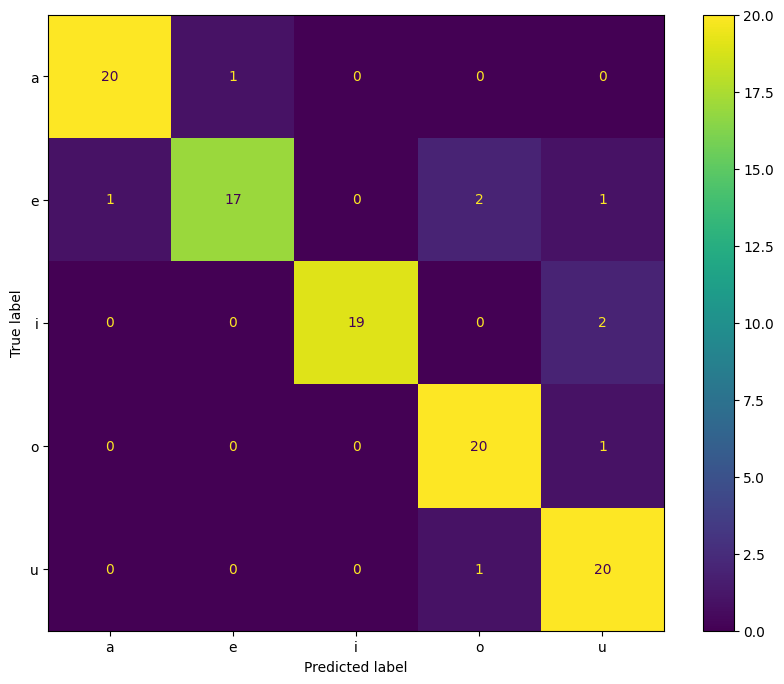

n_fft  =  1024
              precision    recall  f1-score   support

           a       0.91      0.95      0.93        21
           e       0.94      0.81      0.87        21
           i       0.95      0.90      0.93        21
           o       0.91      0.95      0.93        21
           u       0.87      0.95      0.91        21

    accuracy                           0.91       105
   macro avg       0.92      0.91      0.91       105
weighted avg       0.92      0.91      0.91       105

0.9142857142857143


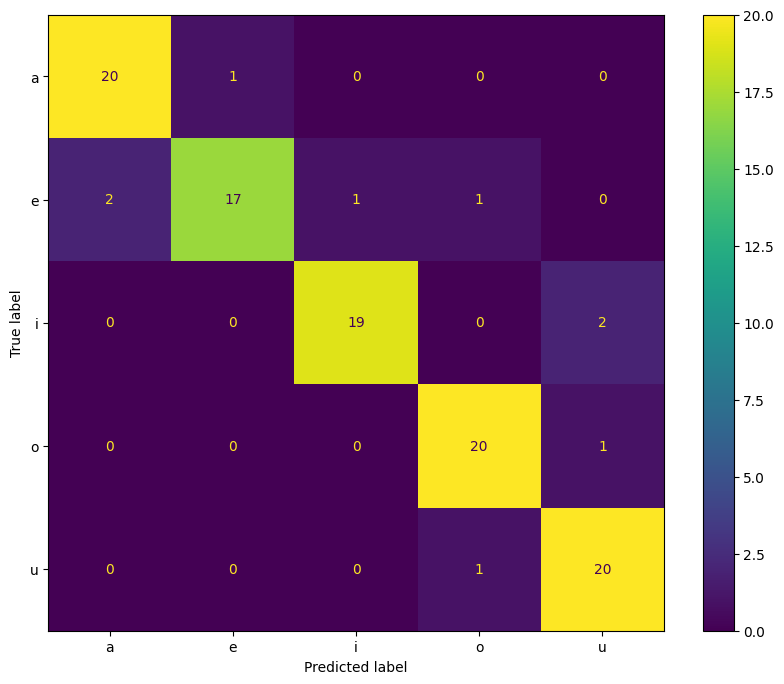

n_fft  =  2048
              precision    recall  f1-score   support

           a       0.95      0.95      0.95        21
           e       0.95      0.86      0.90        21
           i       1.00      0.90      0.95        21
           o       0.86      0.90      0.88        21
           u       0.83      0.95      0.89        21

    accuracy                           0.91       105
   macro avg       0.92      0.91      0.91       105
weighted avg       0.92      0.91      0.91       105

0.9142857142857143


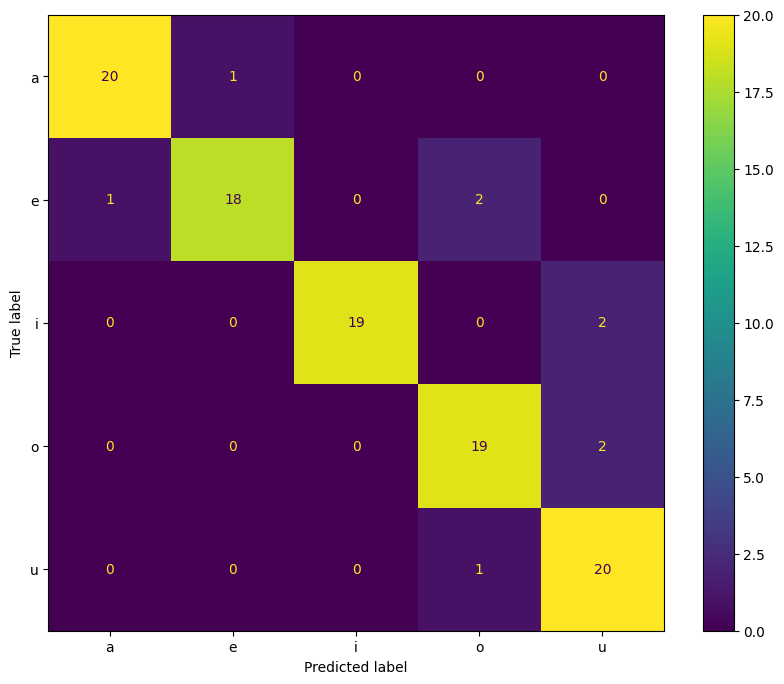

In [19]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import glob
from sklearn import neighbors

config = {
    "train_path":"signals/NguyenAmHuanLuyen-16k",
    "valid_path":"signals/NguyenAmKiemThu-16k",
    "nffts": [512, 1024, 2048],
    "am": ["a", "e", "i", "o", "u"],
    "mfcc": 13,
    "n_neighbors": 10,
}

def euclidean_distance(a, b):
    return abs(a - b)

def load_audio(filename):
    try:
        return librosa.load(filename, sr=None)
    except Exception as e:
        print(f"Cannot load '{filename}': {e}")
        return None

def extract_mfcc(y, sr=22050, n_mfcc=10, n_fft=1024):
    try:
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    except Exception as e:
        print(f"Cannot extract MFCC: {e}")
        return None

def getFeaturesVector(file_path, n_mfcc = 13, n_fft=1024):
  # ==== get label =====================
  filename = os.path.basename(file_path)
  # ====================================

  # === get human say ==================
  human = file_path.split("/")[-2]
  # ====================================

  # Load audio file
  y, fs = librosa.load(file_path, sr=None)

  # Calculate Short-Time Energy (STE)
  window_size = 0.03  # Size of the window (30 ms)
  overlap = 0.5  # Overlap between windows (50%)
  ste_threshold = 0.01  # STE threshold for classifying sound and silence

  # Calculate window parameters
  window_length = int(window_size * fs)
  overlap_length = int(overlap * window_length)

  # Calculate STE for each window
  ste = np.zeros_like(y)
  for i in range(0, len(y) - window_length, window_length - overlap_length):
      window = y[i:i + window_length]
      ste[i:i + window_length] = np.sum(window ** 2)

  # Classify sound and silence
  sound_segments = y[ste > ste_threshold]
  silence_segments = y[ste <= ste_threshold]

  # Create time vectors
  time_sound = np.arange(len(sound_segments)) / fs
  time_silence = np.arange(len(silence_segments)) / fs

  # ==========================
  offset = sound_segments.shape[0]
  # x1 = sound_segments[int(offset * 1/3): int(offset * 2/3)]
  x1 = sound_segments
  # t = time_sound[int(offset * 1/3): int(offset * 2/3)]
  t = time_sound
  time_step = 0.03 # = 30ms
  m = len(np.arange(t[0], t[-1], time_step))

  features = np.zeros((n_mfcc, n_mfcc))
  for (i) in range(m):
    frame = x1[int(x1.shape[0] * i/m ): int(x1.shape[0] * (i + 1)/m)]
    features += extract_mfcc(frame, fs, n_mfcc, n_fft)
  return features / m

for n_fft in config["nffts"]:
  data = {
    "a":[],
    "e":[],
    "i":[],
    "o":[],
    "u":[],
  }

  X, Y = [], []
  for path in glob.glob(config["train_path"] + "/**/*.wav"):
    label = os.path.basename(path).split(".")[0]
    features = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft = n_fft)
    X.append(features)
    Y.append(label)

  X = np.array(X)
  nsamples, nx, ny = X.shape
  X = X.reshape((nsamples,nx*ny))

  # ================
  clf = neighbors.KNeighborsClassifier(n_neighbors = config["n_neighbors"])
  clf.fit(X, Y)


  X_valid = []
  Y_valid = []
  for path in glob.glob(config["valid_path"]+"/**/*.wav"):
      label = os.path.basename(path).split(".")[0]
      features = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft = n_fft)
      X_valid.append(features)
      Y_valid.append(label)

  nsamples, nx, ny = np.array(X_valid).shape
  X_valid = np.array(X_valid).reshape((nsamples,nx*ny))

  print("n_fft  = ", n_fft)
  from sklearn.metrics import classification_report, accuracy_score
  print(classification_report(Y_valid, clf.predict(X_valid)))
  print(accuracy_score(Y_valid, clf.predict(X_valid)))

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  cm = confusion_matrix(Y_valid, clf.predict(X_valid), labels=config["am"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config["am"])
  disp.plot()
  plt.show()

# Bài 3 - MFCC (with Catboost)

In [20]:
!pip install catboost

Learning rate set to 0.493633
0:	learn: 1.3449096	total: 157ms	remaining: 15.6s
1:	learn: 1.1171647	total: 226ms	remaining: 11.1s
2:	learn: 0.9347898	total: 300ms	remaining: 9.71s
3:	learn: 0.7892638	total: 369ms	remaining: 8.86s
4:	learn: 0.6984864	total: 566ms	remaining: 10.8s
5:	learn: 0.6035384	total: 805ms	remaining: 12.6s
6:	learn: 0.5269615	total: 981ms	remaining: 13s
7:	learn: 0.4591039	total: 1.17s	remaining: 13.5s
8:	learn: 0.4107024	total: 1.3s	remaining: 13.1s
9:	learn: 0.3820339	total: 1.48s	remaining: 13.4s
10:	learn: 0.3413498	total: 1.68s	remaining: 13.6s
11:	learn: 0.3107078	total: 1.9s	remaining: 13.9s
12:	learn: 0.2782633	total: 2.09s	remaining: 14s
13:	learn: 0.2530782	total: 2.3s	remaining: 14.1s
14:	learn: 0.2319329	total: 2.49s	remaining: 14.1s
15:	learn: 0.2118792	total: 2.7s	remaining: 14.2s
16:	learn: 0.1971855	total: 2.91s	remaining: 14.2s
17:	learn: 0.1816325	total: 3.05s	remaining: 13.9s
18:	learn: 0.1661531	total: 3.25s	remaining: 13.8s
19:	learn: 0.154010

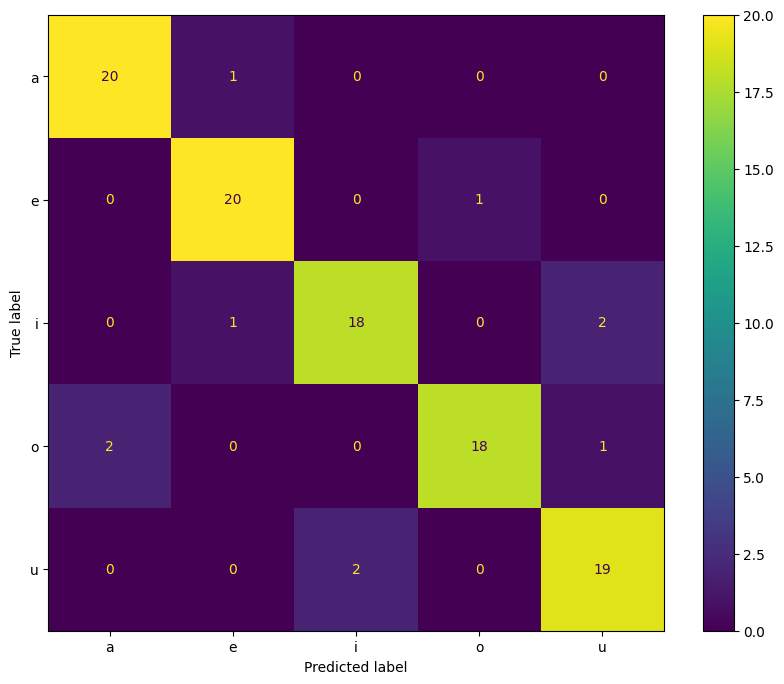

Learning rate set to 0.493633
0:	learn: 1.3792134	total: 146ms	remaining: 14.5s
1:	learn: 1.1405528	total: 215ms	remaining: 10.5s
2:	learn: 0.9602806	total: 283ms	remaining: 9.15s
3:	learn: 0.8373206	total: 357ms	remaining: 8.57s
4:	learn: 0.7441797	total: 426ms	remaining: 8.09s
5:	learn: 0.6229199	total: 490ms	remaining: 7.67s
6:	learn: 0.5470688	total: 557ms	remaining: 7.4s
7:	learn: 0.4921460	total: 621ms	remaining: 7.14s
8:	learn: 0.4494556	total: 694ms	remaining: 7.02s
9:	learn: 0.4111179	total: 760ms	remaining: 6.84s
10:	learn: 0.3792007	total: 825ms	remaining: 6.67s
11:	learn: 0.3449994	total: 894ms	remaining: 6.56s
12:	learn: 0.2990166	total: 967ms	remaining: 6.47s
13:	learn: 0.2700485	total: 1.03s	remaining: 6.34s
14:	learn: 0.2506561	total: 1.1s	remaining: 6.24s
15:	learn: 0.2286434	total: 1.17s	remaining: 6.13s
16:	learn: 0.2078022	total: 1.23s	remaining: 6.02s
17:	learn: 0.1877907	total: 1.3s	remaining: 5.91s
18:	learn: 0.1749795	total: 1.38s	remaining: 5.87s
19:	learn: 0.1

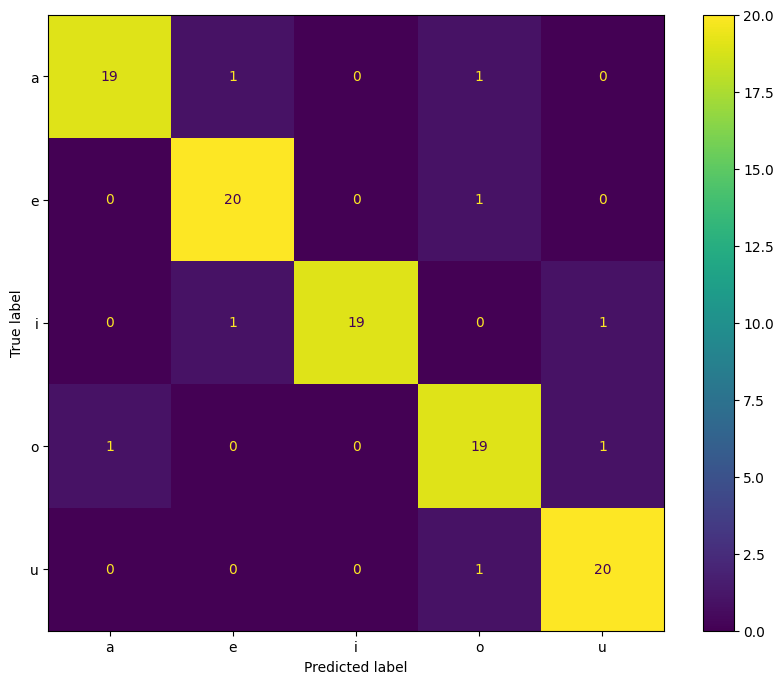

Learning rate set to 0.493633
0:	learn: 1.3535212	total: 137ms	remaining: 13.5s
1:	learn: 1.1317889	total: 209ms	remaining: 10.2s
2:	learn: 0.9658986	total: 274ms	remaining: 8.85s
3:	learn: 0.8334909	total: 338ms	remaining: 8.11s
4:	learn: 0.7279708	total: 403ms	remaining: 7.66s
5:	learn: 0.6021629	total: 472ms	remaining: 7.4s
6:	learn: 0.5342058	total: 538ms	remaining: 7.15s
7:	learn: 0.4713689	total: 603ms	remaining: 6.93s
8:	learn: 0.4142515	total: 682ms	remaining: 6.9s
9:	learn: 0.3728738	total: 746ms	remaining: 6.71s
10:	learn: 0.3303685	total: 817ms	remaining: 6.61s
11:	learn: 0.3017695	total: 880ms	remaining: 6.45s
12:	learn: 0.2666154	total: 948ms	remaining: 6.34s
13:	learn: 0.2443281	total: 1.01s	remaining: 6.23s
14:	learn: 0.2190199	total: 1.08s	remaining: 6.1s
15:	learn: 0.2063282	total: 1.14s	remaining: 6s
16:	learn: 0.1951993	total: 1.21s	remaining: 5.92s
17:	learn: 0.1814664	total: 1.28s	remaining: 5.83s
18:	learn: 0.1693189	total: 1.34s	remaining: 5.74s
19:	learn: 0.1572

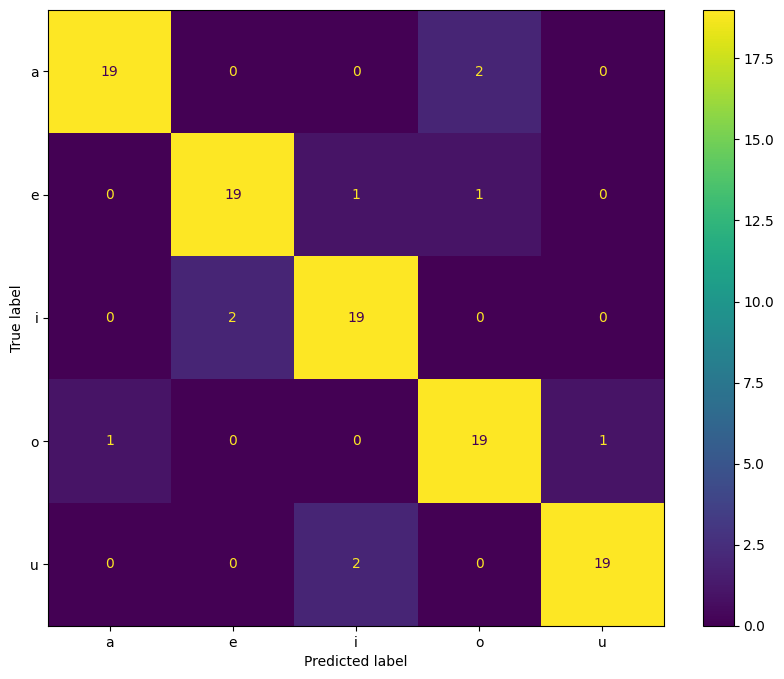

In [21]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import glob
from catboost import CatBoostClassifier

config = {
    "train_path":"signals/NguyenAmHuanLuyen-16k",
    "valid_path":"signals/NguyenAmKiemThu-16k",
    "nffts": [512, 1024, 2048],
    "am": ["a", "e", "i", "o", "u"],
    "mfcc": 13,
    "n_estimators": 100,
}

def euclidean_distance(a, b):
    return abs(a - b)

def load_audio(filename):
    try:
        return librosa.load(filename, sr=None)
    except Exception as e:
        print(f"Cannot load '{filename}': {e}")
        return None

def extract_mfcc(y, sr=22050, n_mfcc=10, n_fft=1024):
    try:
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    except Exception as e:
        print(f"Cannot extract MFCC: {e}")
        return None

def getFeaturesVector(file_path, n_mfcc = 13, n_fft=1024):
  # ==== get label =====================
  filename = os.path.basename(file_path)
  # ====================================

  # === get human say ==================
  human = file_path.split("/")[-2]
  # ====================================

  # Load audio file
  y, fs = librosa.load(file_path, sr=None)

  # Calculate Short-Time Energy (STE)
  window_size = 0.03  # Size of the window (30 ms)
  overlap = 0.5  # Overlap between windows (50%)
  ste_threshold = 0.01  # STE threshold for classifying sound and silence

  # Calculate window parameters
  window_length = int(window_size * fs)
  overlap_length = int(overlap * window_length)

  # Calculate STE for each window
  ste = np.zeros_like(y)
  for i in range(0, len(y) - window_length, window_length - overlap_length):
      window = y[i:i + window_length]
      ste[i:i + window_length] = np.sum(window ** 2)

  # Classify sound and silence
  sound_segments = y[ste > ste_threshold]
  silence_segments = y[ste <= ste_threshold]

  # Create time vectors
  time_sound = np.arange(len(sound_segments)) / fs
  time_silence = np.arange(len(silence_segments)) / fs

  # ==========================
  offset = sound_segments.shape[0]
  # x1 = sound_segments[int(offset * 1/3): int(offset * 2/3)]
  x1 = sound_segments
  # t = time_sound[int(offset * 1/3): int(offset * 2/3)]
  t = time_sound
  time_step = 0.03 # = 30ms
  m = len(np.arange(t[0], t[-1], time_step))

  features = np.zeros((n_mfcc, n_mfcc))
  for (i) in range(m):
    frame = x1[int(x1.shape[0] * i/m ): int(x1.shape[0] * (i + 1)/m)]
    features += extract_mfcc(frame, fs, n_mfcc, n_fft)
  return features / m

for n_fft in config["nffts"]:
  data = {
    "a":[],
    "e":[],
    "i":[],
    "o":[],
    "u":[],
  }

  X, Y = [], []
  for path in glob.glob(config["train_path"] + "/**/*.wav"):
    label = os.path.basename(path).split(".")[0]
    features = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft = n_fft)
    X.append(features)
    Y.append(label)

    from sklearn import neighbors

  X = np.array(X)
  nsamples, nx, ny = X.shape
  X = X.reshape((nsamples,nx*ny))

  # ================
  clf = CatBoostClassifier(n_estimators=100)
  clf.fit(X,Y)


  X_valid = []
  Y_valid = []
  for path in glob.glob(config["valid_path"]+"/**/*.wav"):
      label = os.path.basename(path).split(".")[0]
      features = getFeaturesVector(path, n_mfcc=config["mfcc"], n_fft = n_fft)
      X_valid.append(features)
      Y_valid.append(label)

  nsamples, nx, ny = np.array(X_valid).shape
  X_valid = np.array(X_valid).reshape((nsamples,nx*ny))

  print("n_fft  = ", n_fft)
  from sklearn.metrics import classification_report, accuracy_score
  print(classification_report(Y_valid, clf.predict(X_valid)))
  print(accuracy_score(Y_valid, clf.predict(X_valid)))

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  cm = confusion_matrix(Y_valid, clf.predict(X_valid), labels=config["am"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config["am"])
  disp.plot()
  plt.show()